In [267]:
import pandas as pd
from prophet import Prophet

# Load the retail data
df_raw = pd.read_csv("retail-usa-clothing.csv", parse_dates=True)


In [268]:
df_raw

date    state           item  quantity       region country
0       1997-11-25  NewYork  mens_clothing         8  Mid-Alantic     USA
1       1997-11-26  NewYork  mens_clothing         9  Mid-Alantic     USA
2       1997-11-27  NewYork  mens_clothing        11  Mid-Alantic     USA
3       1997-11-28  NewYork  mens_clothing        11  Mid-Alantic     USA
4       1997-11-29  NewYork  mens_clothing        10  Mid-Alantic     USA
...            ...      ...            ...       ...          ...     ...
388019  2009-07-24  NewYork     mens_shoes        16  Mid-Alantic     USA
388020  2009-07-25  NewYork     mens_shoes        17  Mid-Alantic     USA
388021  2009-07-26  NewYork     mens_shoes        19  Mid-Alantic     USA
388022  2009-07-27  NewYork     mens_shoes        17  Mid-Alantic     USA
388023  2009-07-28  NewYork     mens_shoes        19  Mid-Alantic     USA

[388024 rows x 6 columns]

In [269]:
import pandas as pd

# Assuming df is your DataFrame containing the sales data
# Convert 'date' column to datetime format if it's not already in datetime format
df_raw['date'] = pd.to_datetime(df_raw['date'])

# Group the data by 'state', 'region', 'item', and the end date of each month, and sum the quantity
df_raw = df_raw.groupby([pd.Grouper(key='date', freq='M', closed='right'), 'state', 'item']).agg({'quantity': 'sum'}).reset_index()


# Display the DataFrame showing the sum of quantity for each item in each state and region for each month


C:\Users\mvssa\AppData\Local\Temp\ipykernel_28248\1193158683.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_raw = df_raw.groupby([pd.Grouper(key='date', freq='M', closed='right'), 'state', 'item']).agg({'quantity': 'sum'}).reset_index()


In [270]:
def hierarchical_forecast_prophet(df, hierarchy_level,period:int):
    # Group the data by hierarchy level and sum the quantity sold
    #df_grouped = df.groupby(hierarchy_level + ['date'])['quantity'].sum().reset_index()

    # Rename columns to match Prophet's requirements
    df_grouped = df.rename(columns={'date': 'ds', 'quantity': 'y'})
    #print(df_grouped)
    # Instantiate Prophet model
    model = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.01)


    # Fit the model to the data
    model.fit(df_grouped)

    # Make future dataframe for forecasting with monthly frequency
    future = model.make_future_dataframe(periods=period, freq='M',include_history=False)  # Forecasting for 4 months (adjust as needed)
    

    # Make predictions
    forecast = model.predict(future)

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [276]:
# Filter the DataFrame to include data only until December 2008
df_filtered = df_raw[(df_raw['date'] >= '2006-01-01') & (df_raw['date'] <= '2007-12-31')]

In [277]:
df_filtered

date      state             item  quantity
10010 2007-01-31    Alabama    kids_clothing      1776
10011 2007-01-31    Alabama       kids_shoes       358
10012 2007-01-31    Alabama    mens_clothing       337
10013 2007-01-31    Alabama       mens_shoes       397
10014 2007-01-31    Alabama  womens_clothing      5973
...          ...        ...              ...       ...
12189 2008-12-31  Tennessee     womens_shoes       924
12190 2008-12-31    Vermont       kids_shoes       348
12191 2008-12-31    Vermont    mens_clothing      1220
12192 2008-12-31    Vermont  womens_clothing     11216
12193 2008-12-31    Vermont     womens_shoes      1456

[2184 rows x 4 columns]

In [278]:
# Dictionary to store forecasts
forecasts_data = {'item': [], 'state': [], 'ds': [], 'yhat': [], 'yhat_lower': [], 'yhat_upper': []}

for item in df_filtered['item'].unique():
    item_df = df_filtered[df_filtered['item'] == item]

    # State forecasts
    for state in item_df['state'].unique():
        #state_df = df_filtered[df_filtered['state'] == state
    
        state_df = item_df[(item_df['state'] == state) ]
        #region=state_df['region'].unique()[0]
        #print(state_df)
        state_forecast = hierarchical_forecast_prophet(state_df, ['state'],period=7)

        # Store forecast data
        forecasts_data['item'].extend([item] * len(state_forecast))
        forecasts_data['state'].extend([state]* len(state_forecast))
        #forecasts_data['state_region'].extend([region + "_" + state] * len(state_forecast))
        forecasts_data['ds'].extend(state_forecast['ds'])
        forecasts_data['yhat'].extend(state_forecast['yhat'])
        forecasts_data['yhat_lower'].extend(state_forecast['yhat_lower'])
        forecasts_data['yhat_upper'].extend(state_forecast['yhat_upper'])




20:13:56 - cmdstanpy - INFO - Chain [1] start processing
20:13:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mvssa\anaconda3\envs\TimeSeries\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
20:13:56 - cmdstanpy - INFO - Chain [1] start processing
20:13:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mvssa\anaconda3\envs\TimeSeries\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
20:13:56 - cmdstanpy - INFO - Chain [1] start processing
20:13:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mvssa\anaconda3\envs\TimeSeries\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
20:13:57 - cmdstanpy - INFO 

In [279]:
drop=True

In [280]:
# Convert 'ds' column to datetime if it's not already in datetime format
forecasts_df = pd.DataFrame(forecasts_data)

forecasts_df['ds'] = pd.to_datetime(forecasts_df['ds'])
forecasts_df['unique_combo']=forecasts_df['state']+"/"+forecasts_df["item"]
# Set the 'ds' column as the index
if drop:
    forecasts_df=forecasts_df.drop(columns=['state','item'])
forecasts_df.set_index(['unique_combo','ds'], inplace=True)

# Print the DataFrame with the sum of yhat values for each item in each state and region


                                         yhat   yhat_lower   yhat_upper
unique_combo          ds                                               
Alabama/kids_clothing 2009-01-31  2541.879352  2474.815914  2609.023976
                      2009-02-28  2566.521358  2470.056122  2668.734487
                      2009-03-31  2593.803578  2443.465777  2763.982324
                      2009-04-30  2620.205727  2392.157416  2864.122105
                      2009-05-31  2647.487947  2332.743564  2974.819848
...                                       ...          ...          ...
Vermont/womens_shoes  2009-03-31  1439.529163  1393.855906  1483.665106
                      2009-04-30  1442.052740  1394.929210  1488.850221
                      2009-05-31  1444.660436  1397.415738  1492.530022
                      2009-06-30  1447.184013  1401.217253  1493.914542
                      2009-07-31  1449.791709  1400.127958  1498.693987

[637 rows x 3 columns]


In [281]:
# Filter the DataFrame to include data for Alabama and the first month of January 2009
df_gt = df_raw[(df_raw['date'] >= '2009-01-01')]
df_gt['unique_combo']=df_gt['state']+"/"+df_gt['item']
if drop:
    df_gt=df_gt.drop(columns=['state','item'])
df_gt=df_gt.rename(columns={"date":"ds"})
df_gt=df_gt.groupby(['unique_combo','ds']).agg({'quantity': 'sum'})
# Print the filtered DataFrame
#alabama_gt=alabama_gt.loc['kids_clothing',:]


                                  quantity
unique_combo          ds                  
Alabama/kids_clothing 2009-01-31      2280
                      2009-02-28      2146
                      2009-03-31      2504
                      2009-04-30      2432
                      2009-05-31      2525
...                                    ...
Vermont/womens_shoes  2009-03-31      1451
                      2009-04-30      1396
                      2009-05-31      1435
                      2009-06-30      1394
                      2009-07-31      1308

[637 rows x 1 columns]


C:\Users\mvssa\AppData\Local\Temp\ipykernel_28248\3831257392.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gt['unique_combo']=df_gt['state']+"/"+df_gt['item']


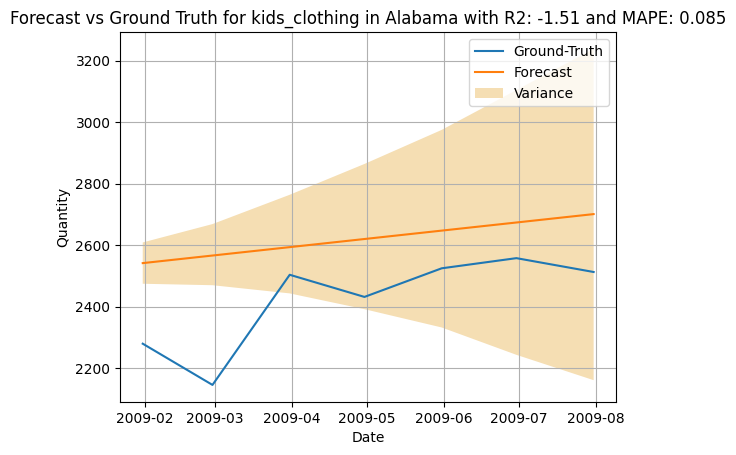

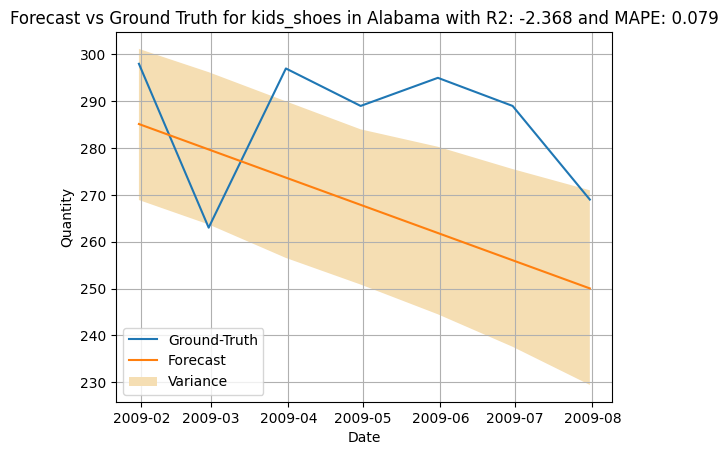

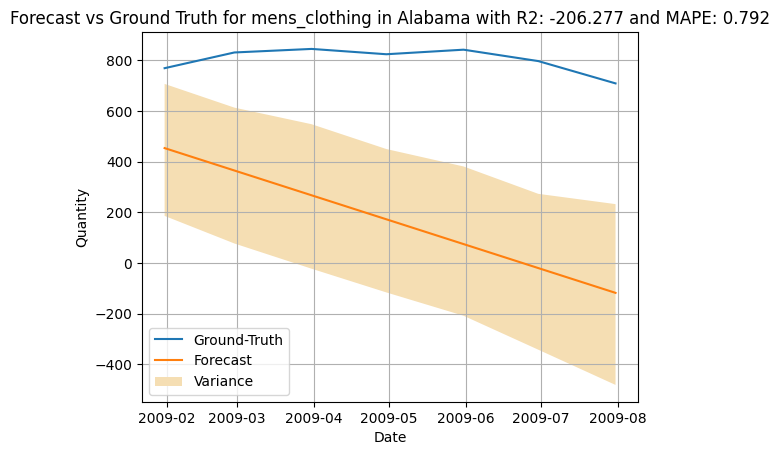

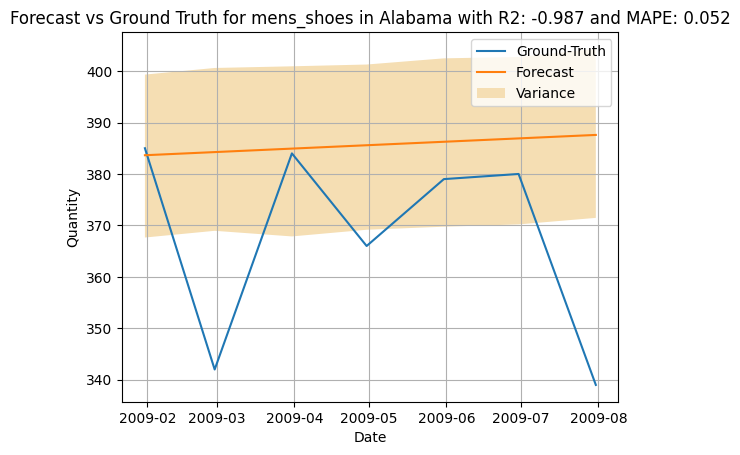

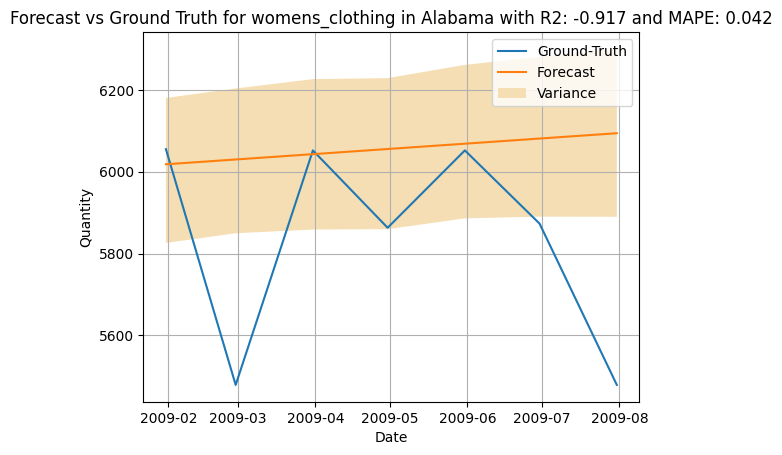

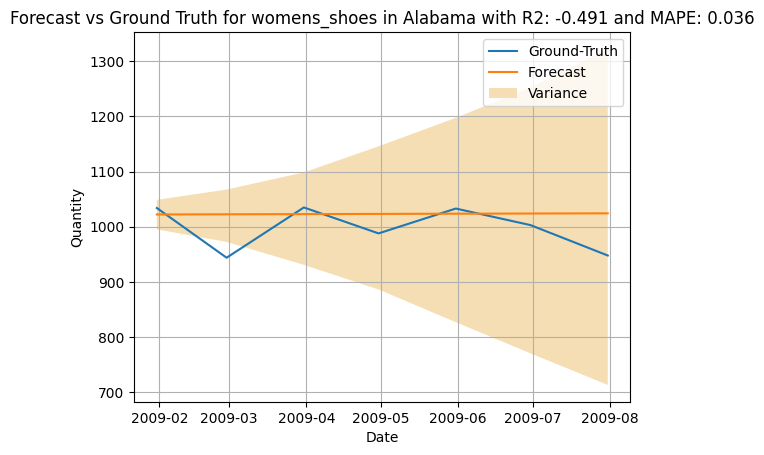

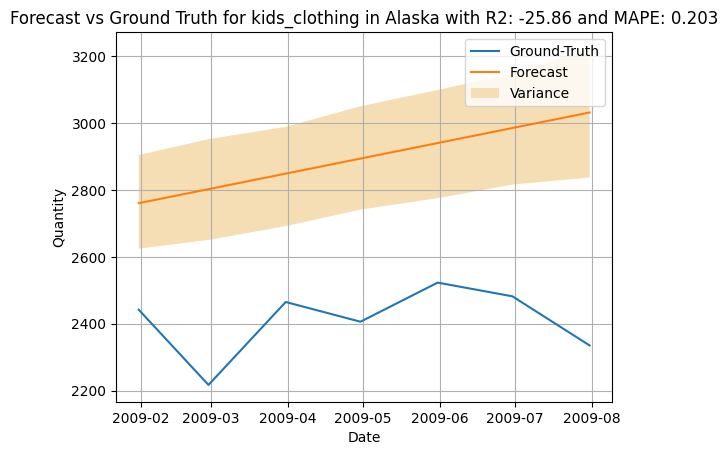

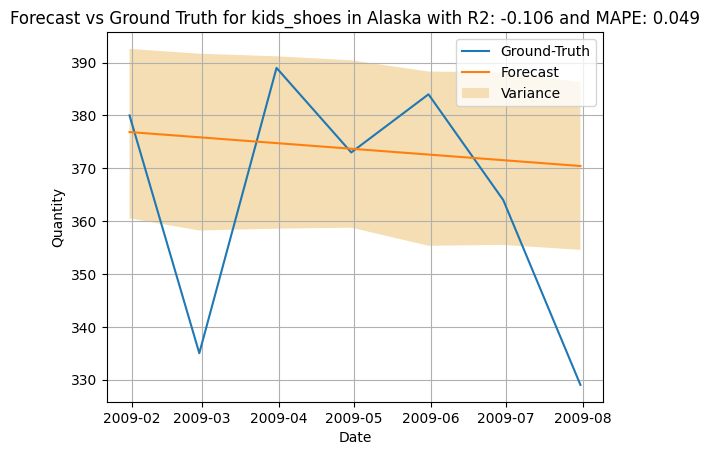

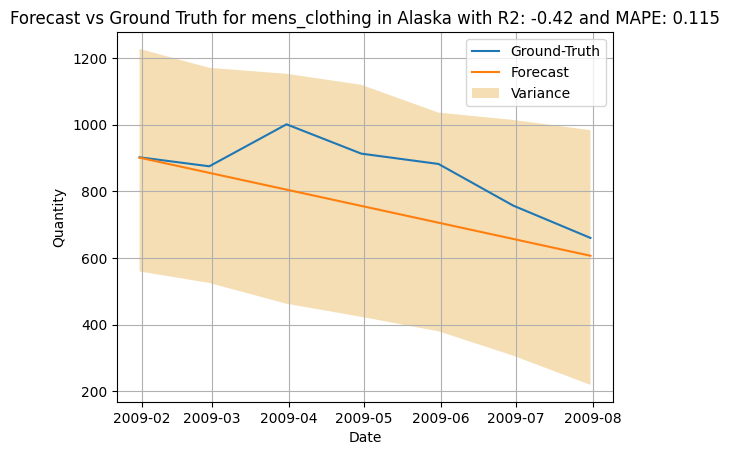

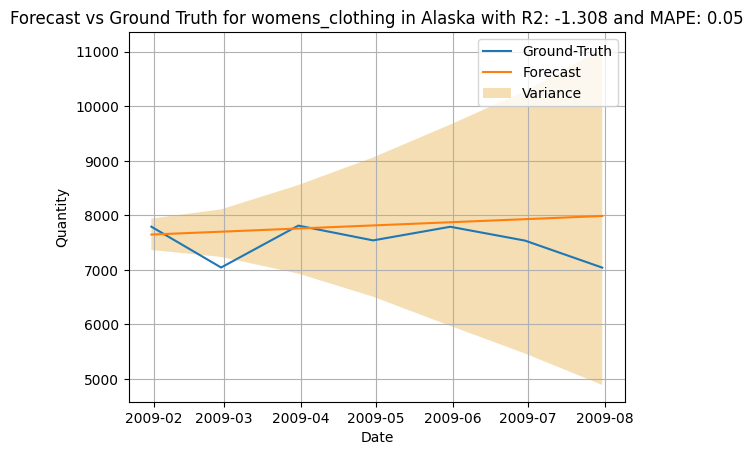

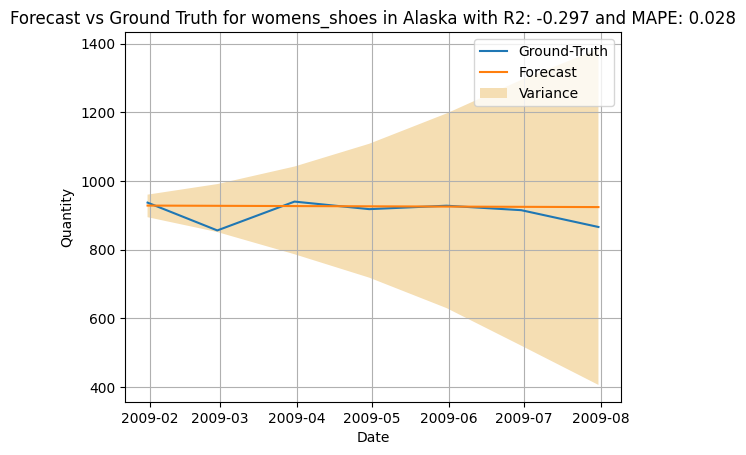

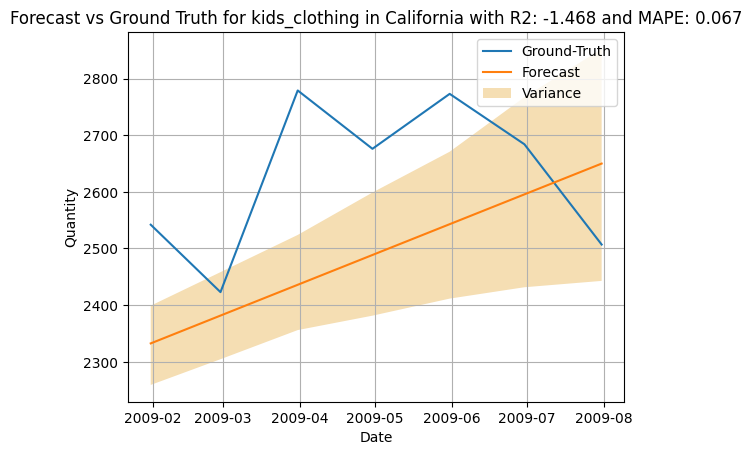

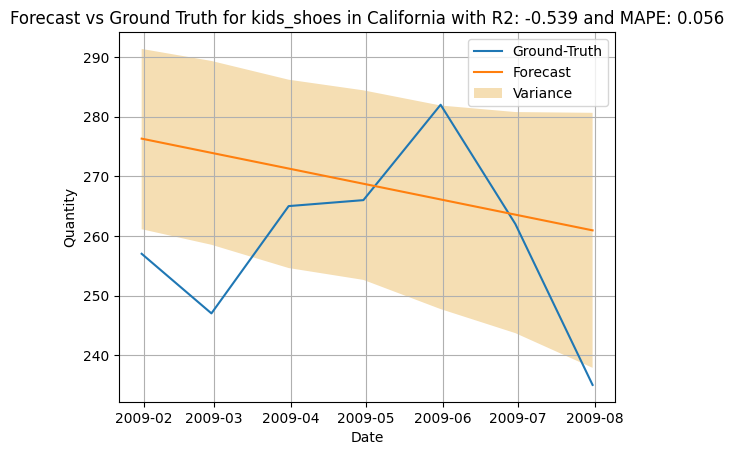

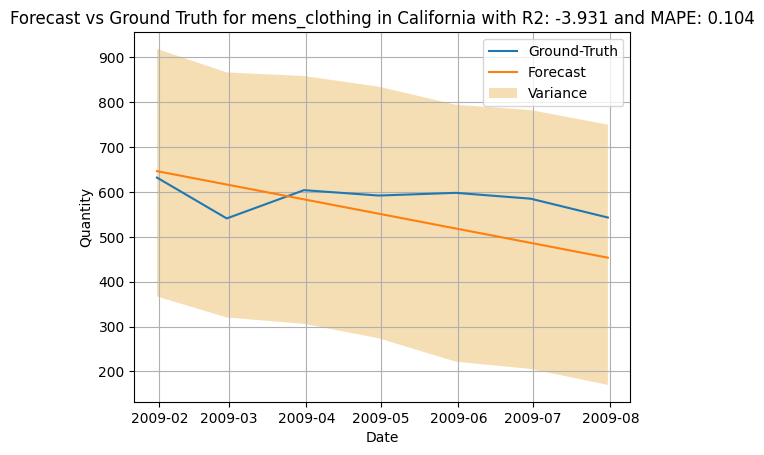

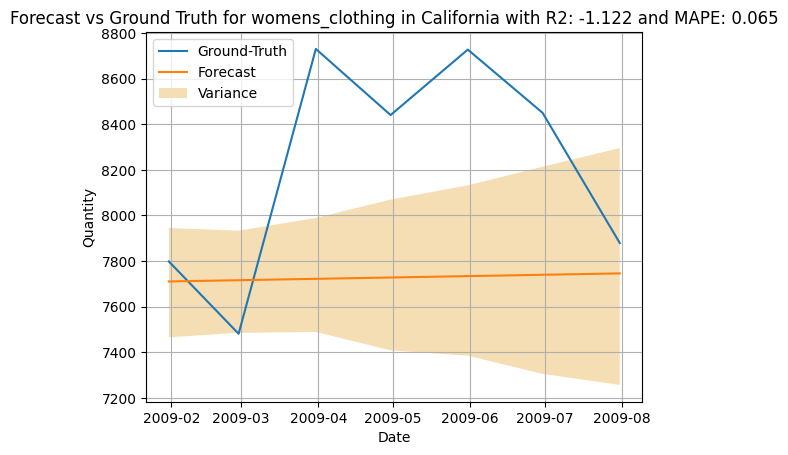

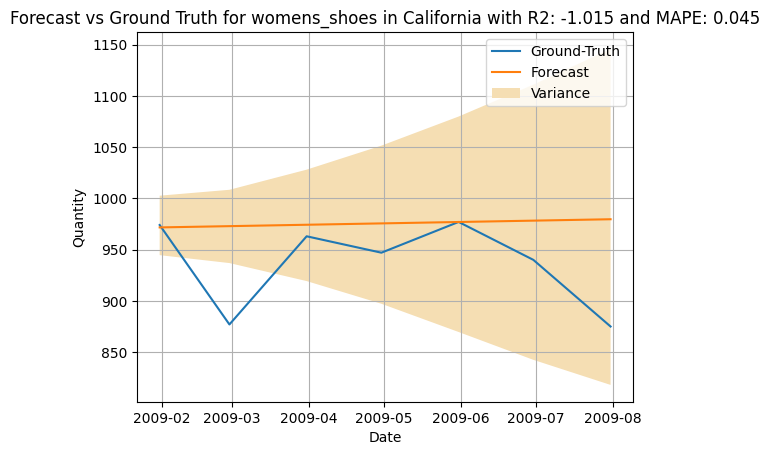

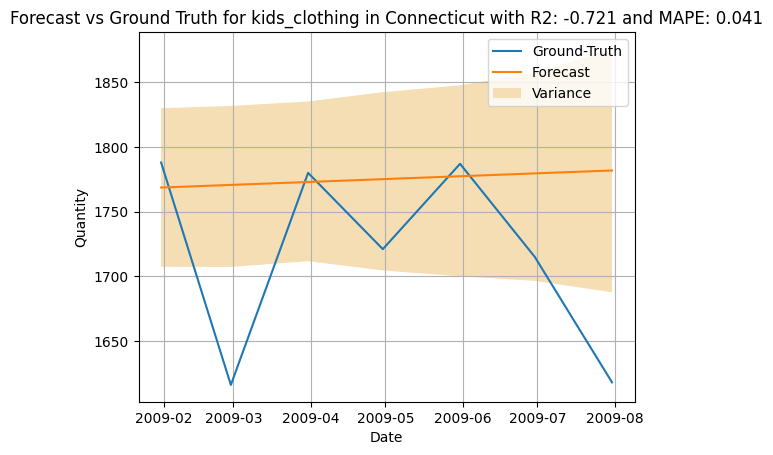

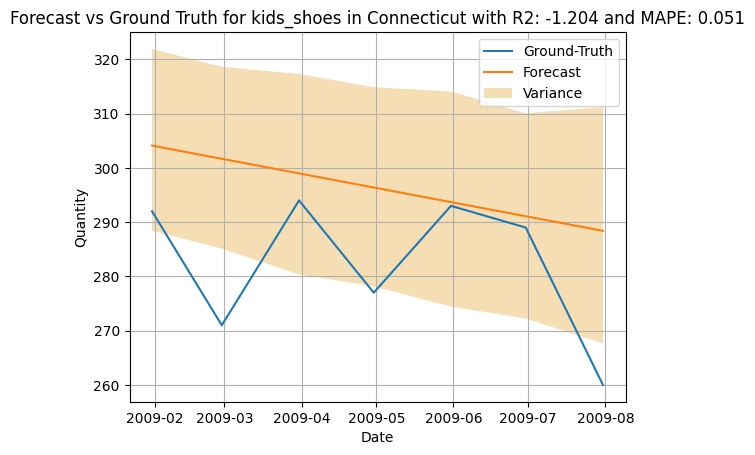

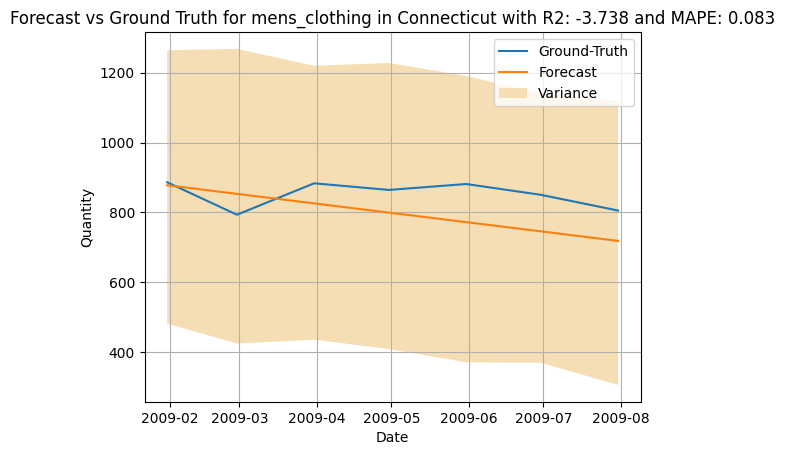

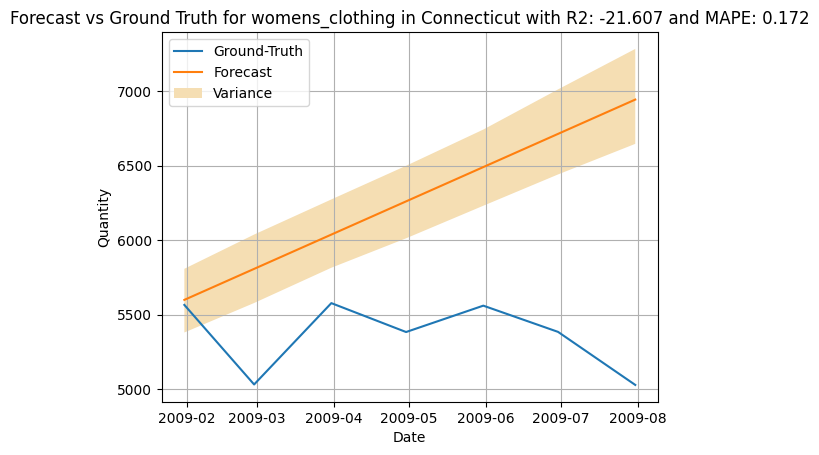

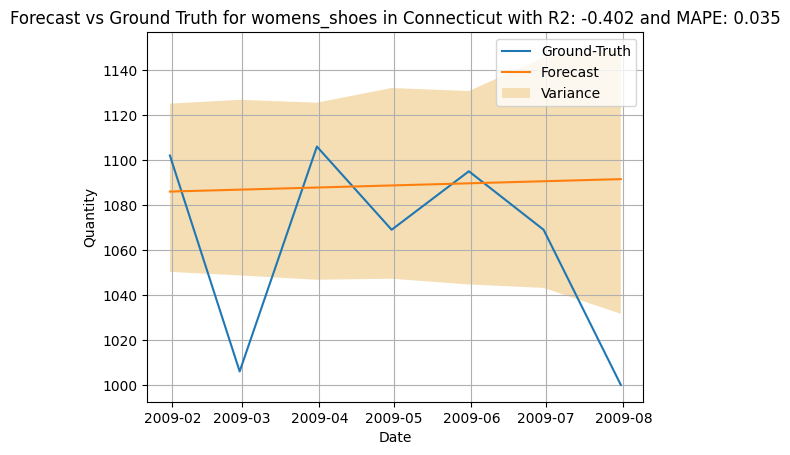

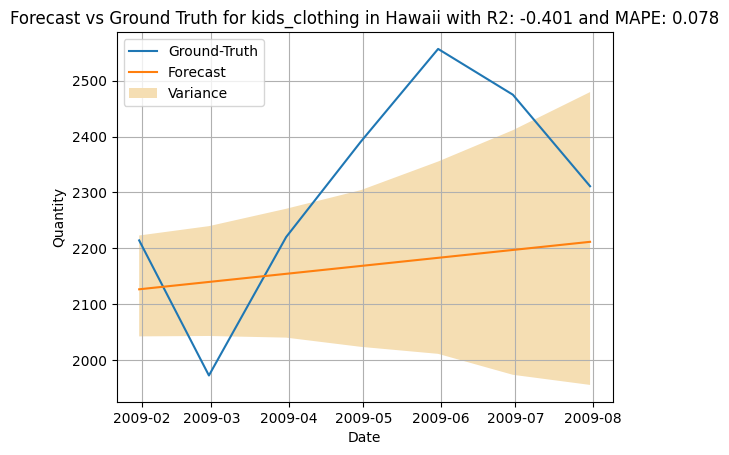

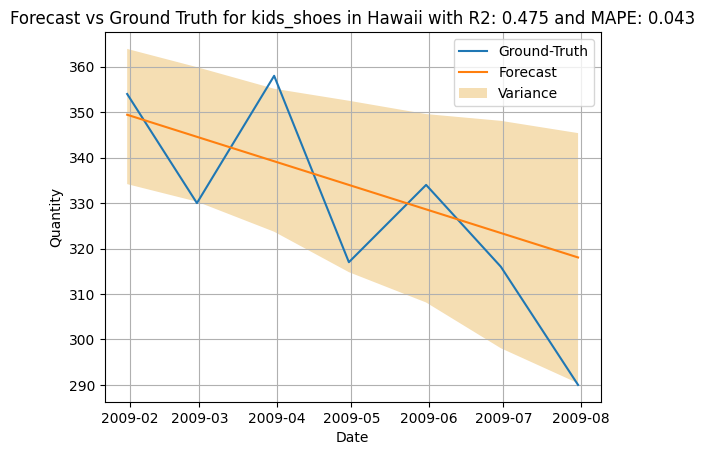

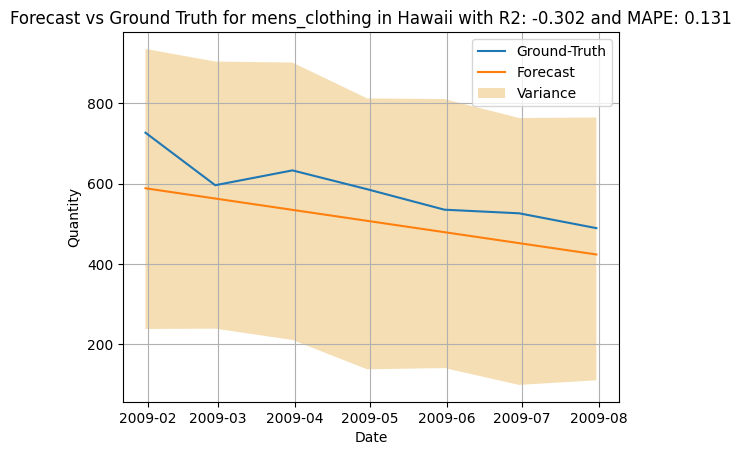

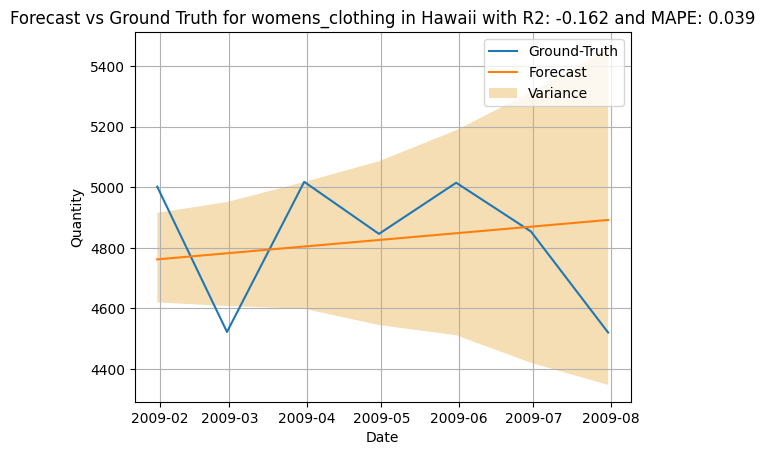

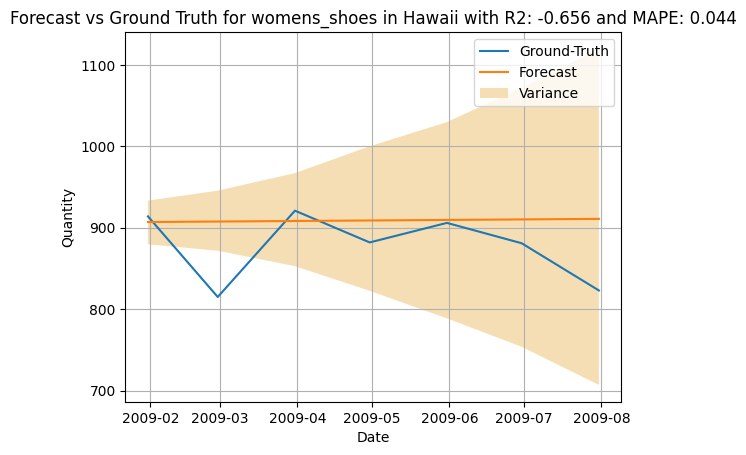

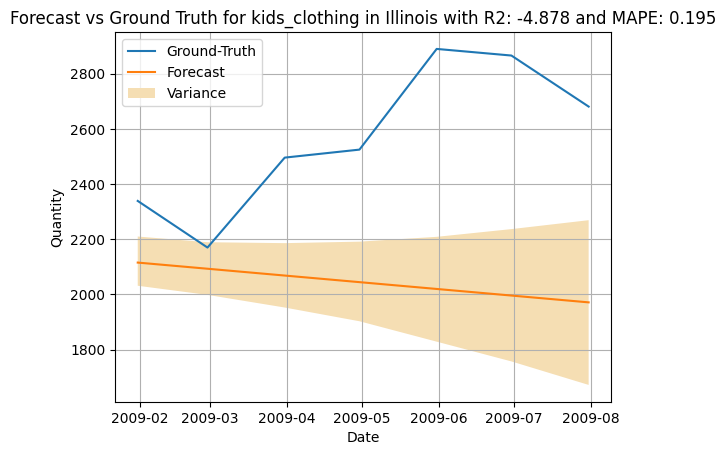

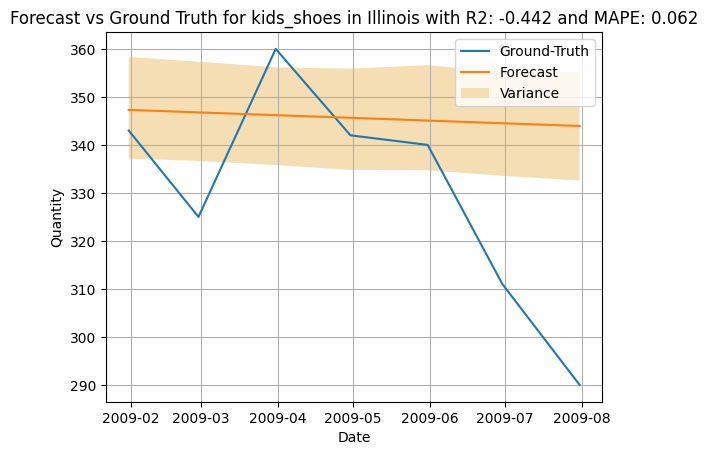

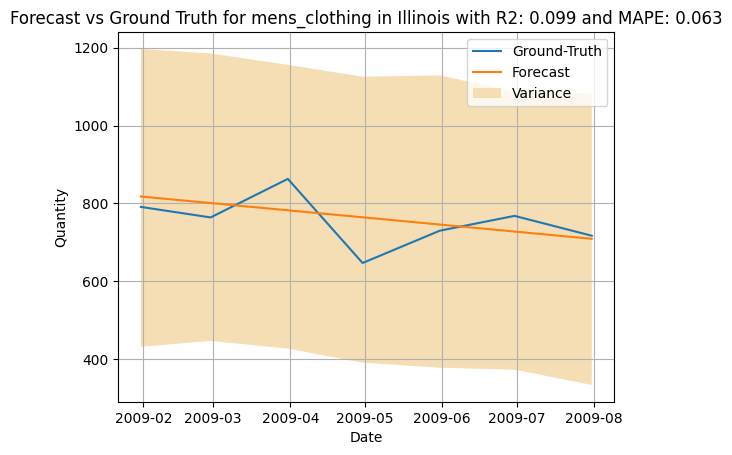

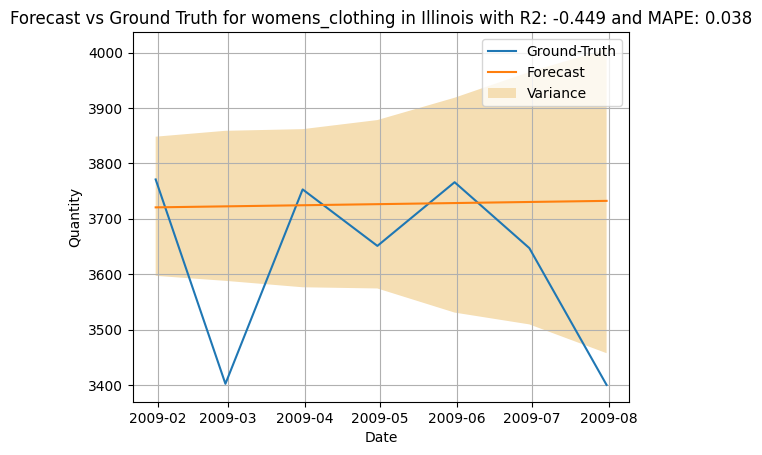

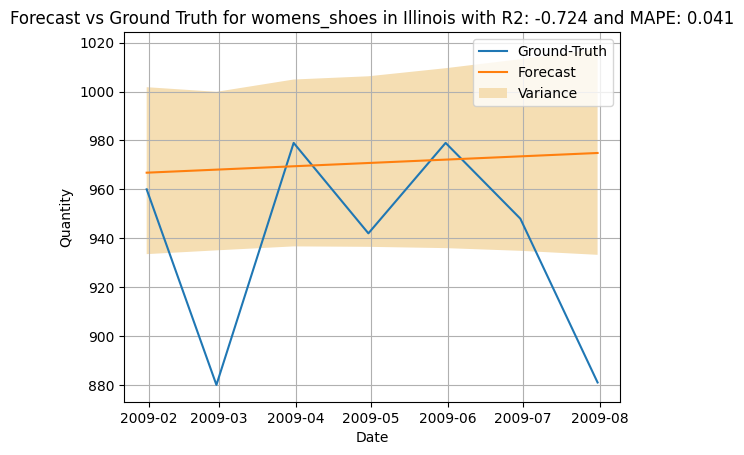

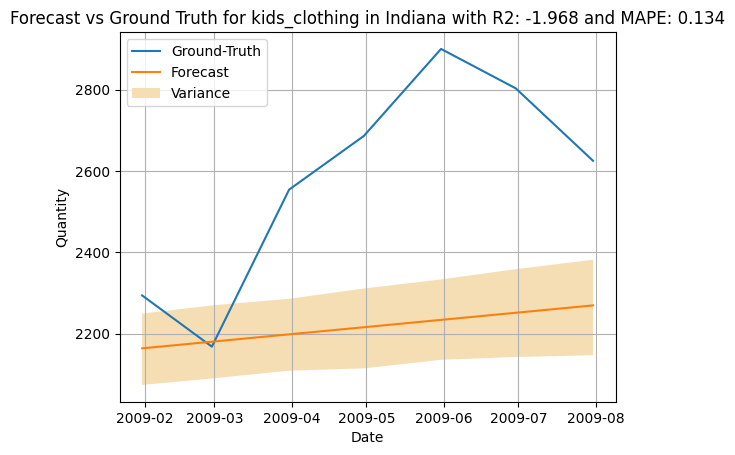

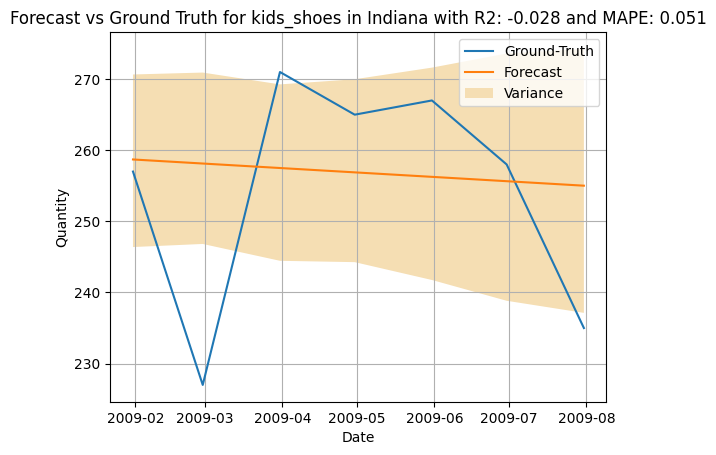

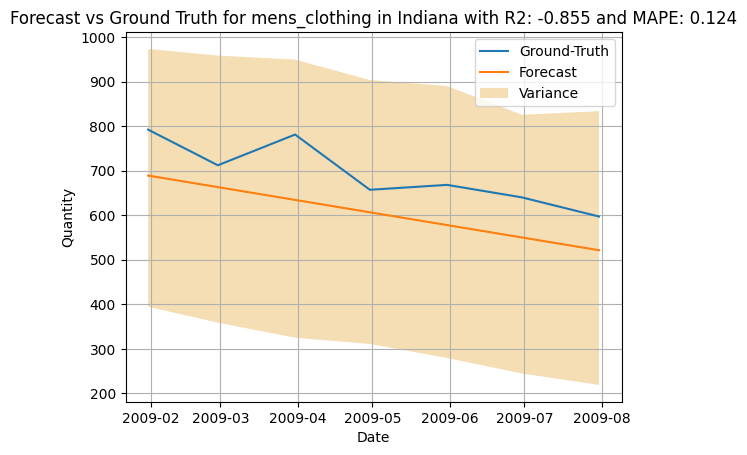

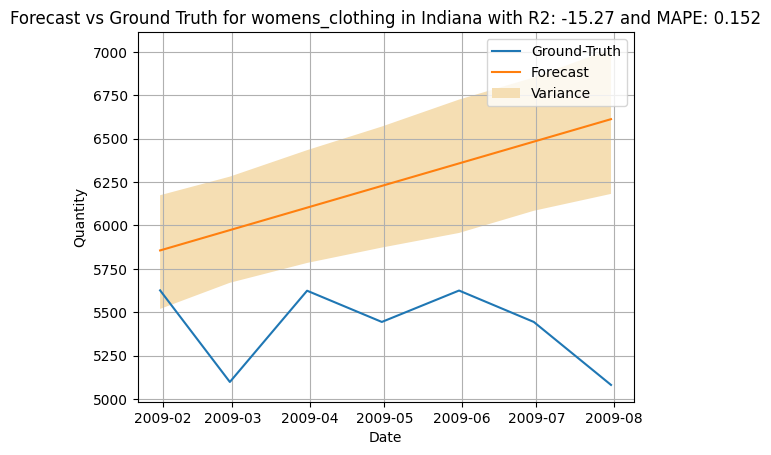

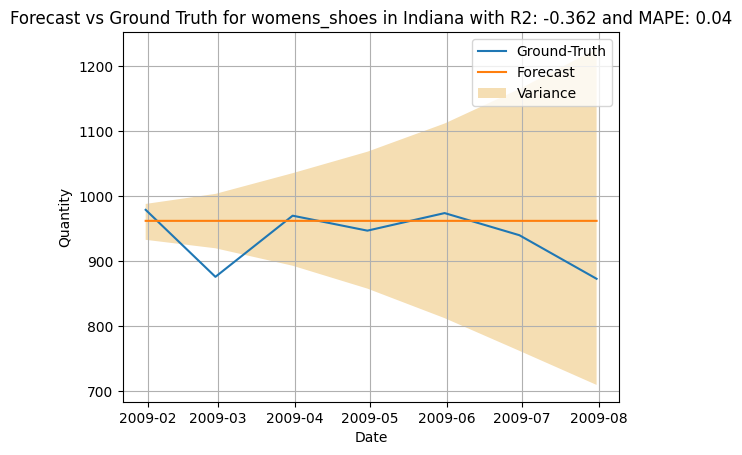

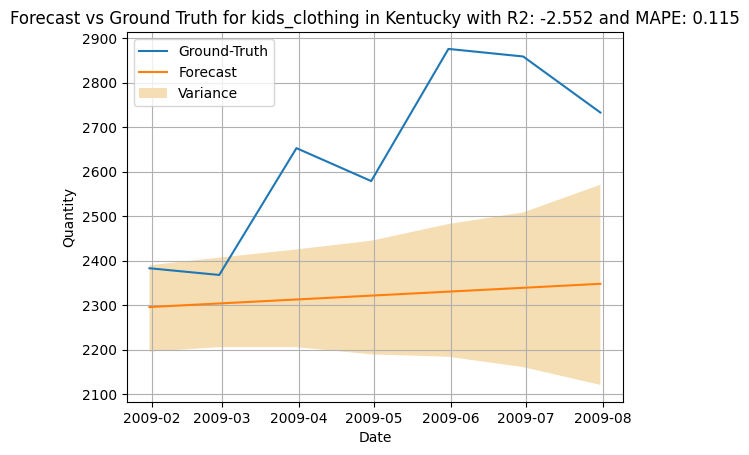

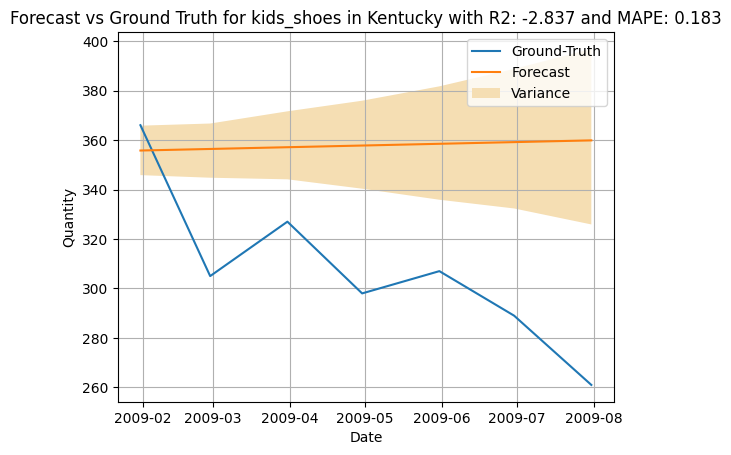

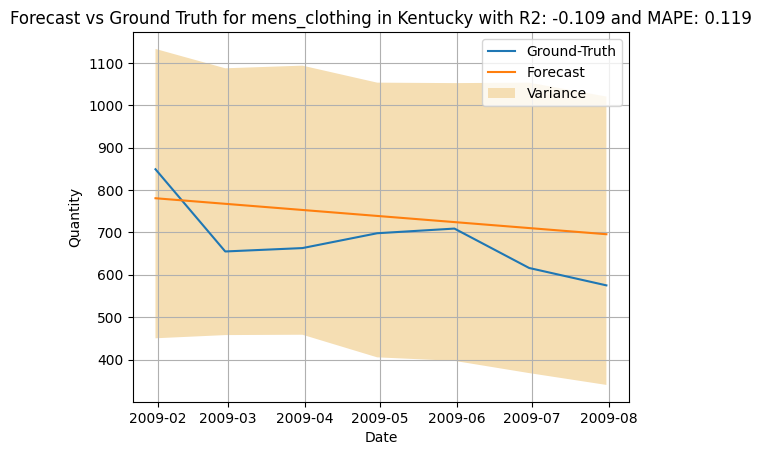

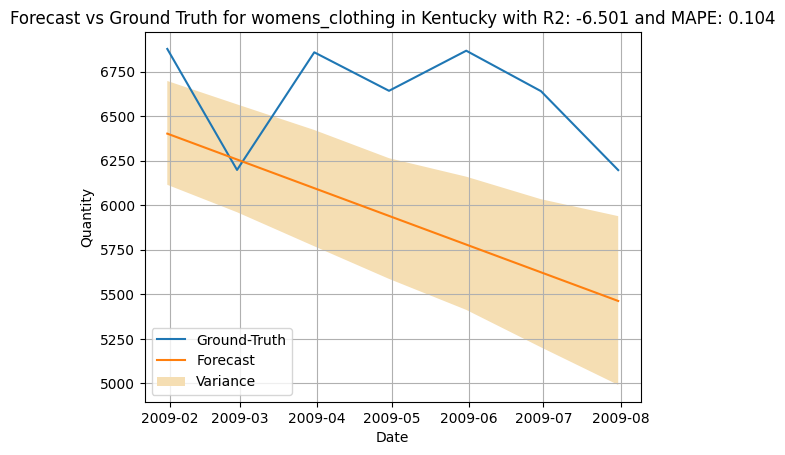

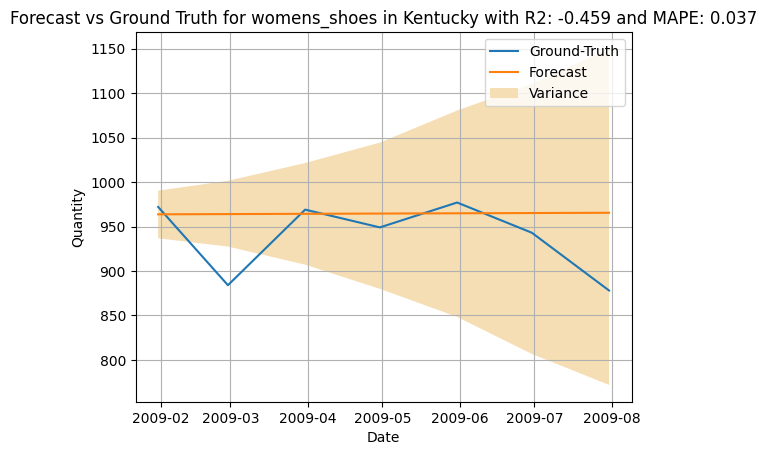

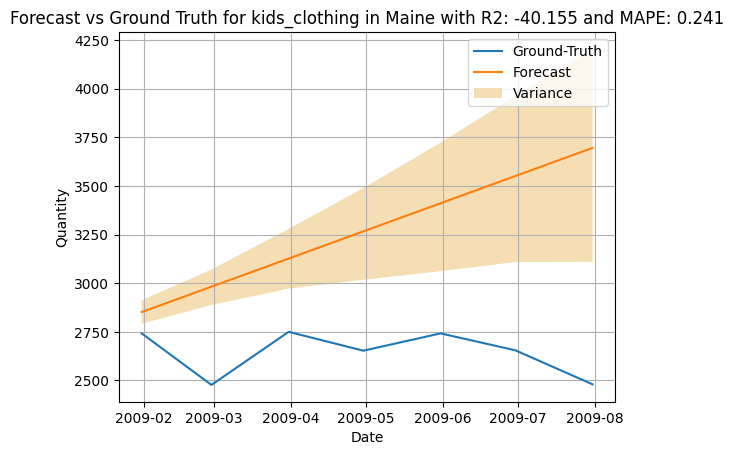

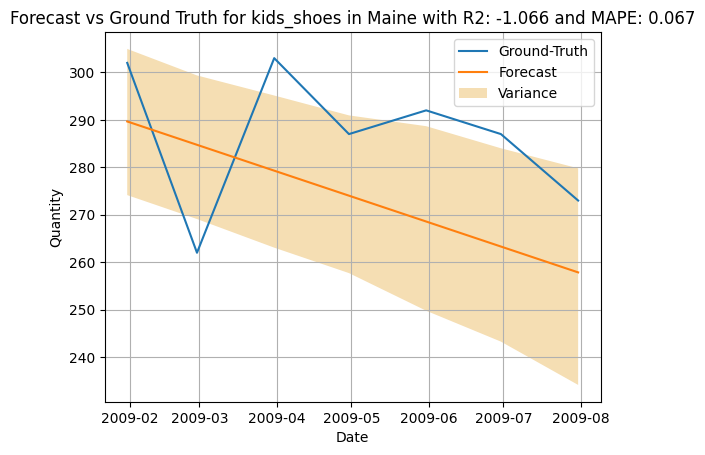

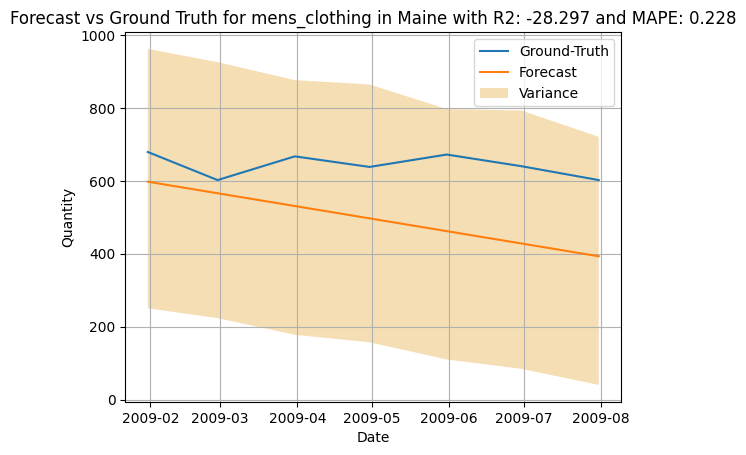

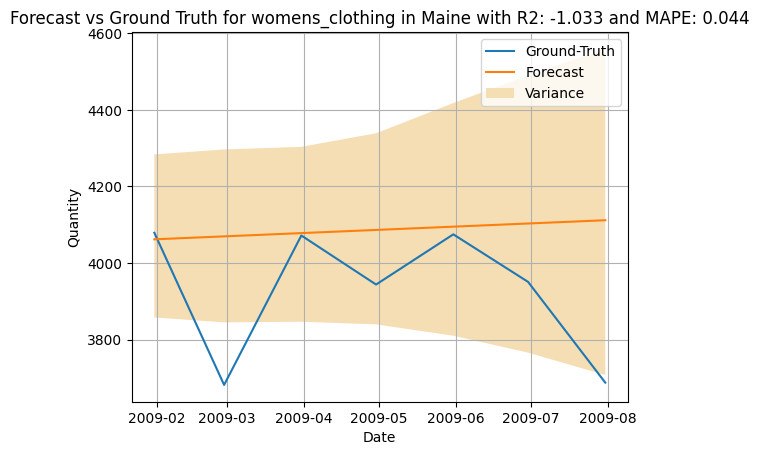

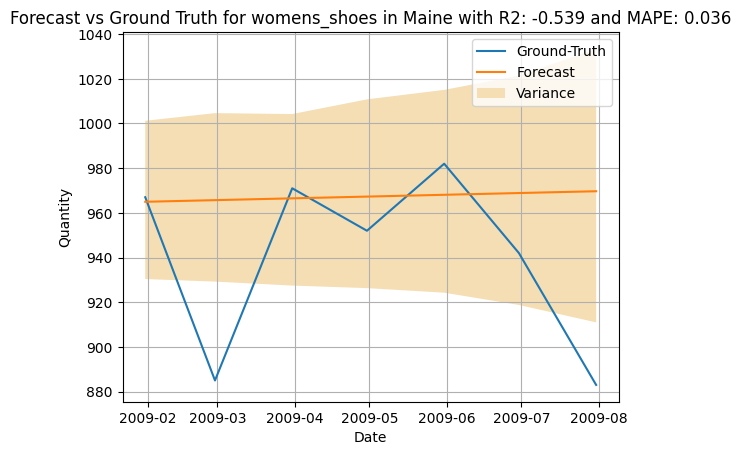

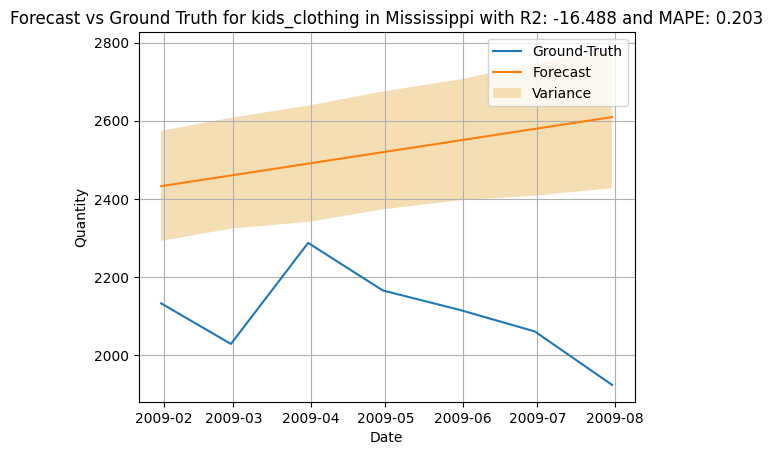

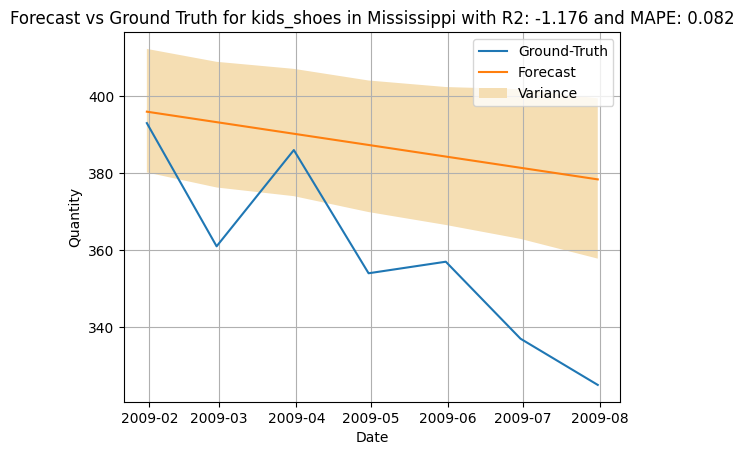

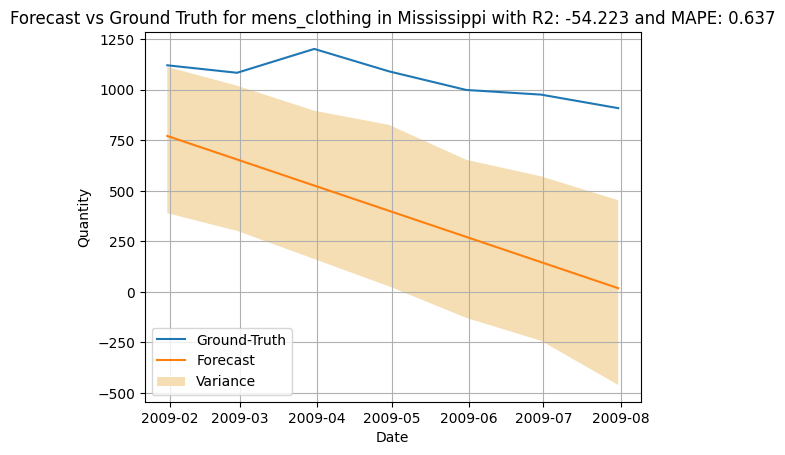

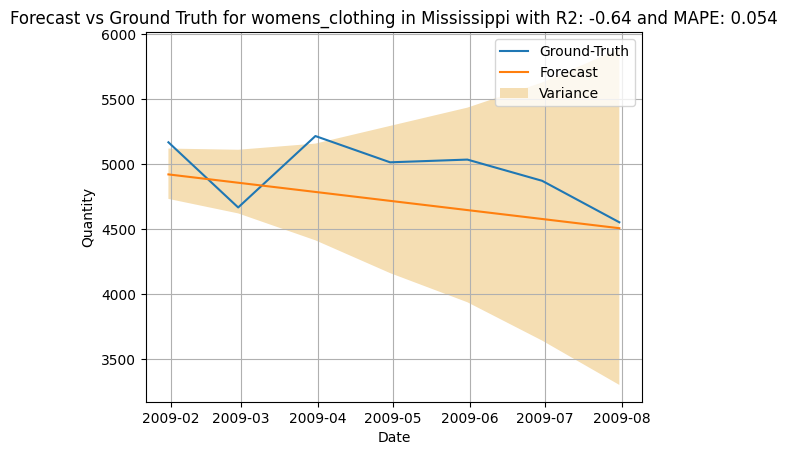

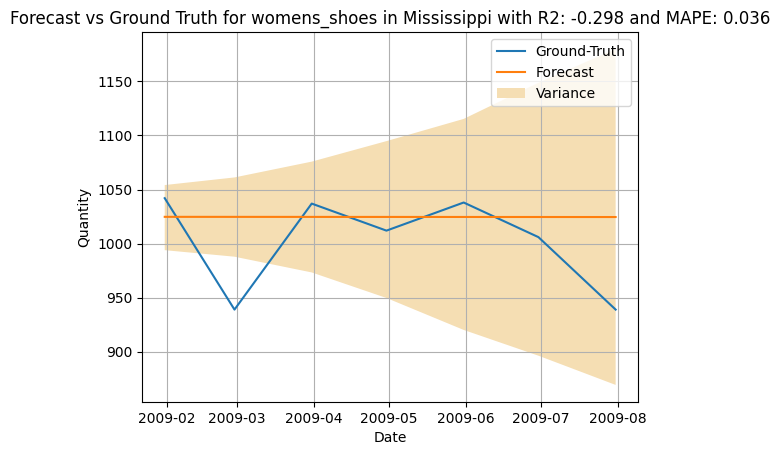

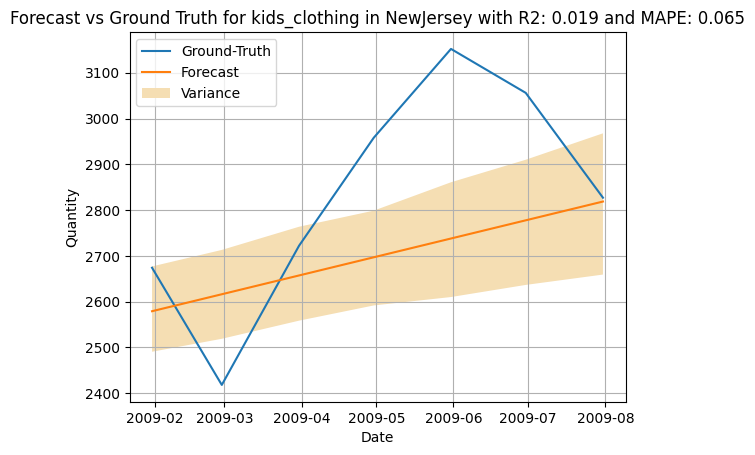

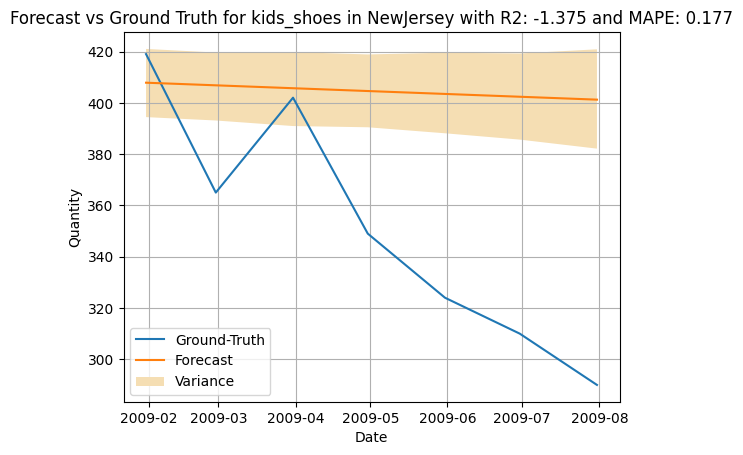

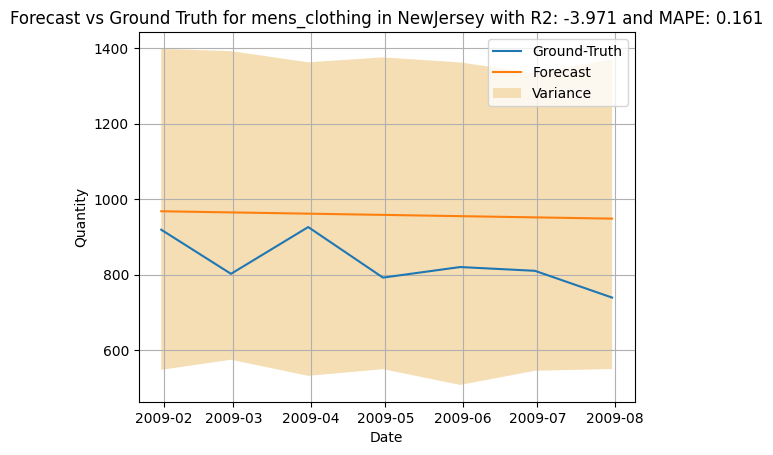

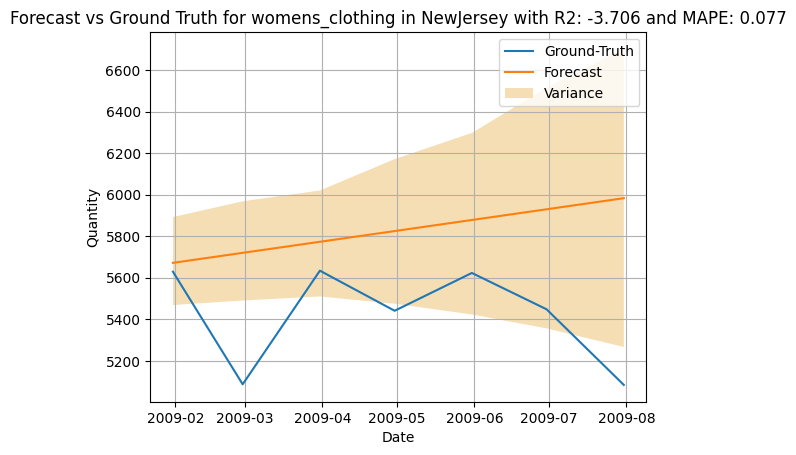

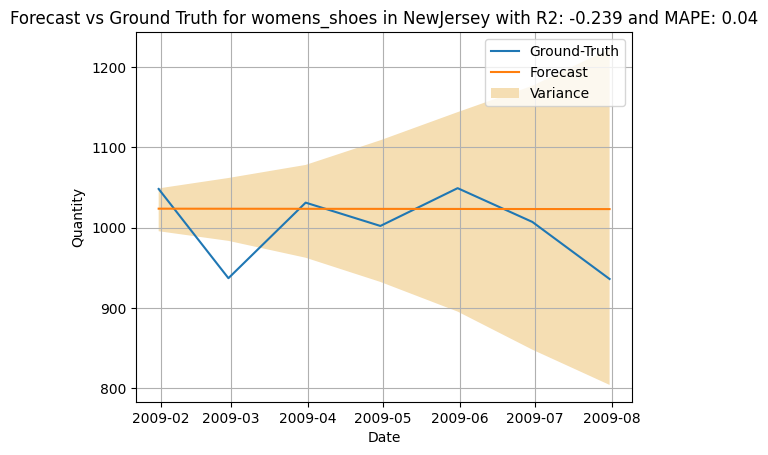

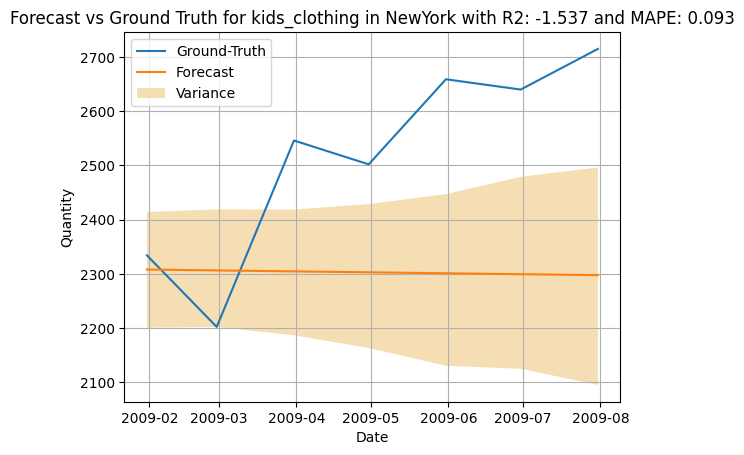

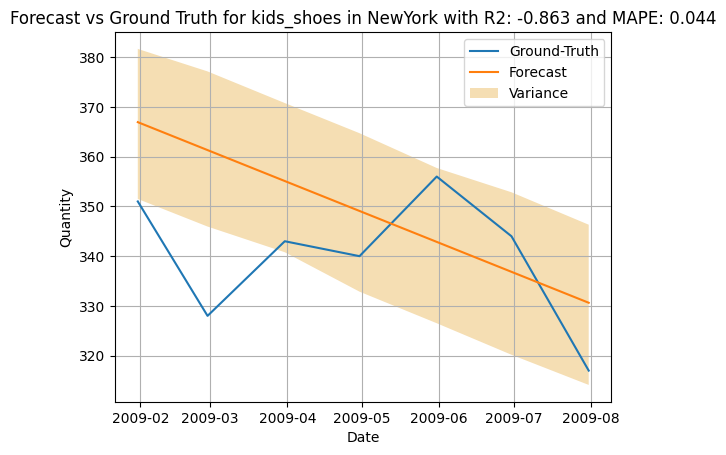

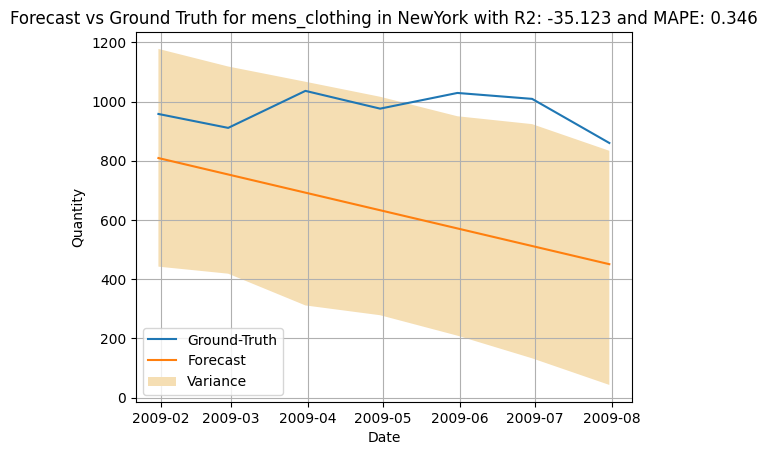

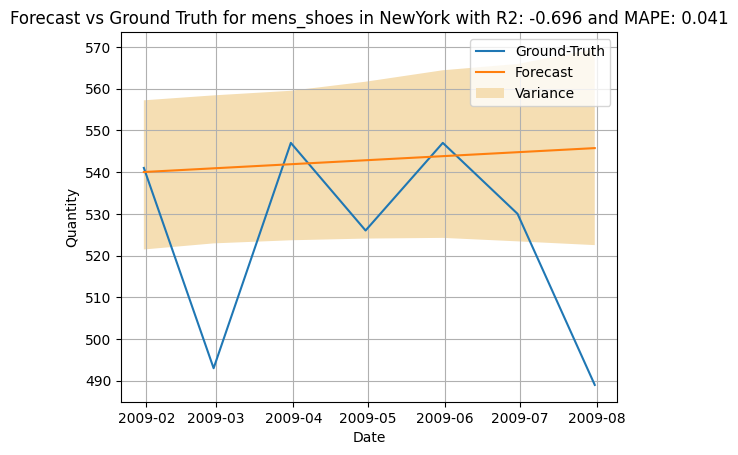

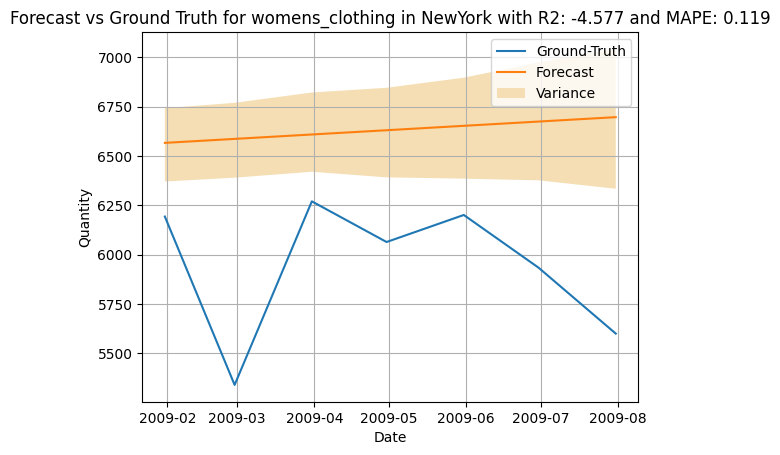

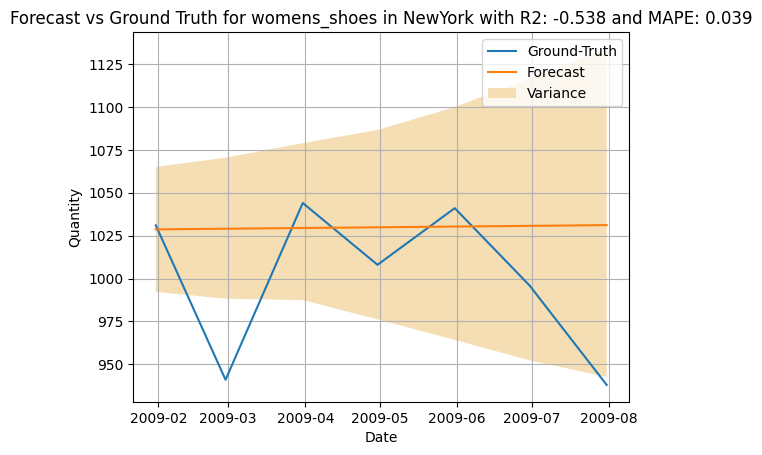

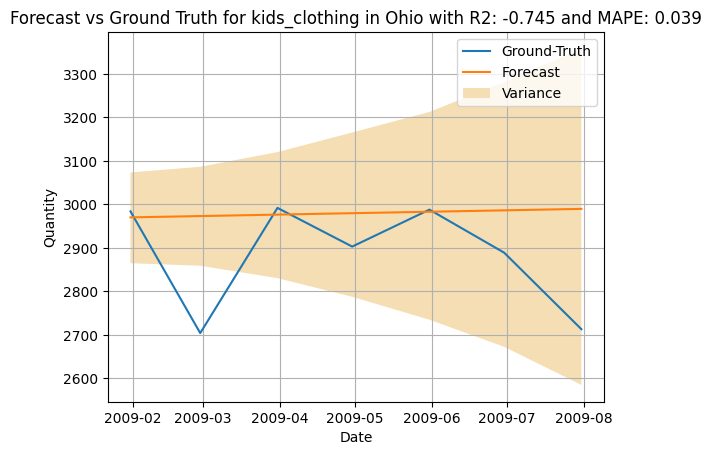

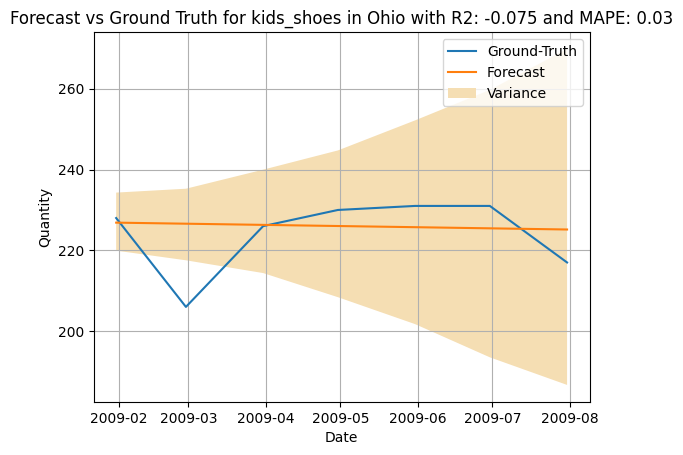

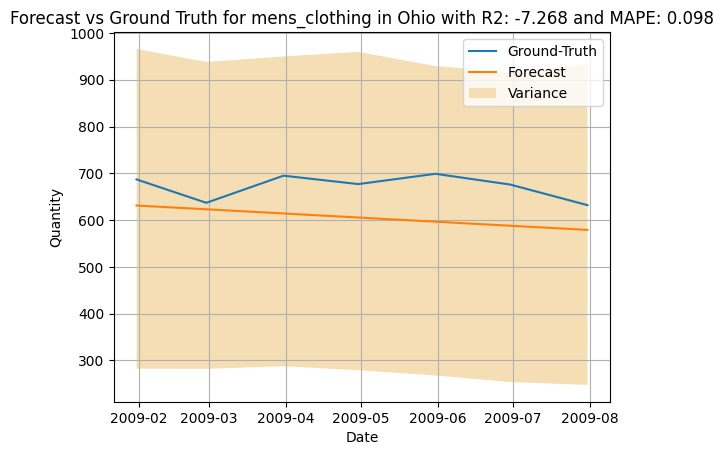

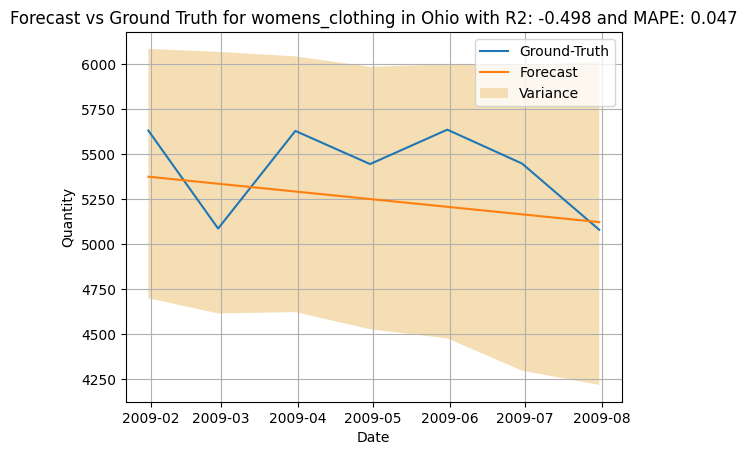

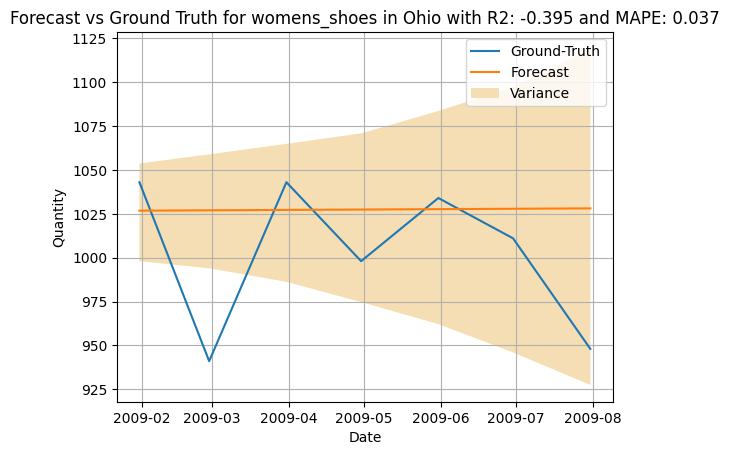

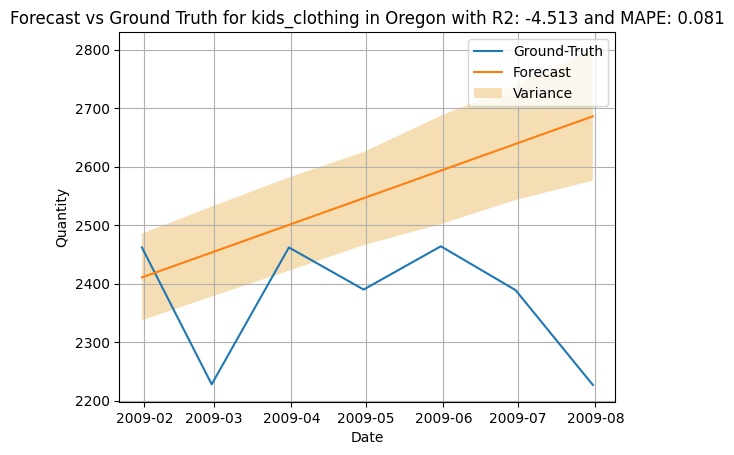

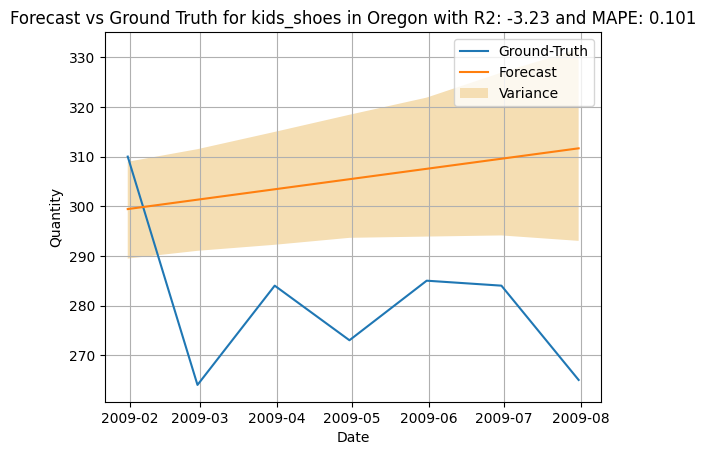

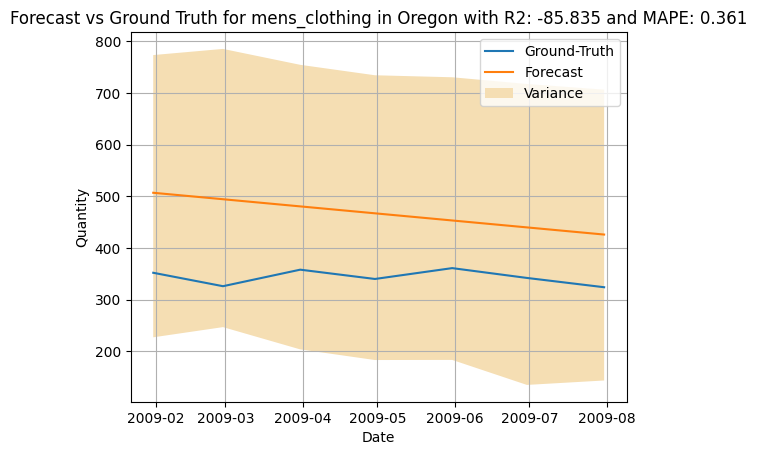

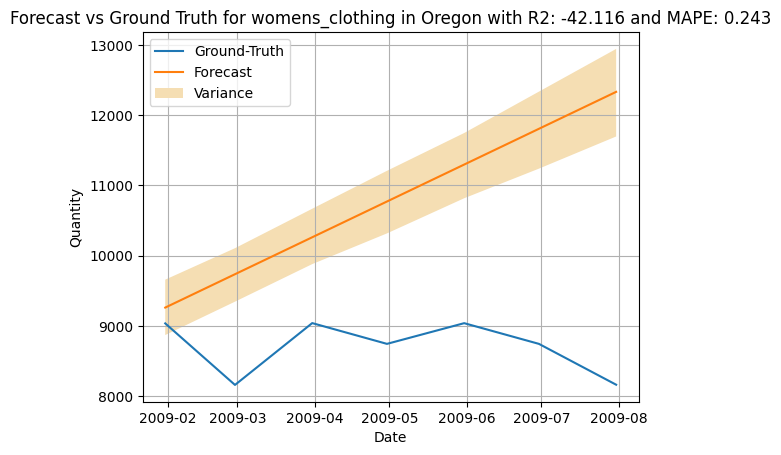

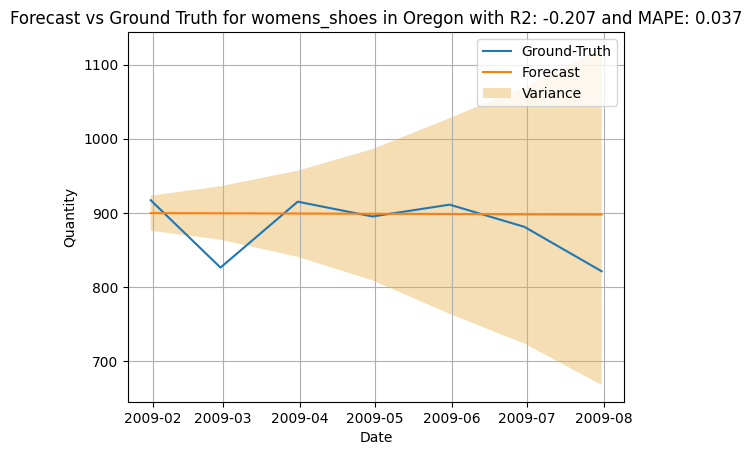

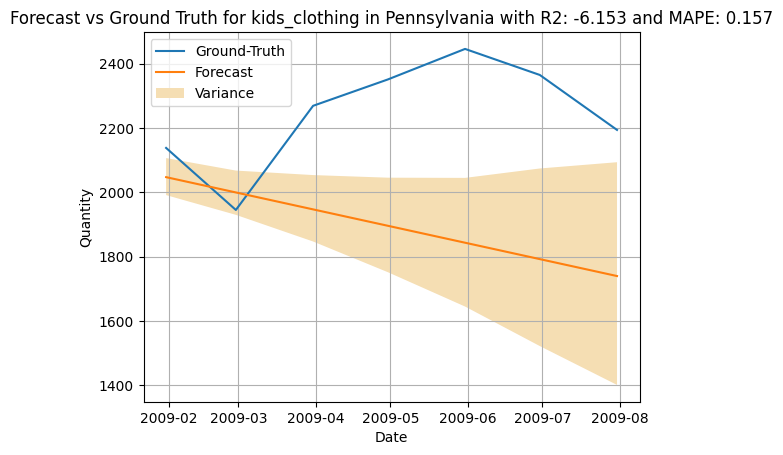

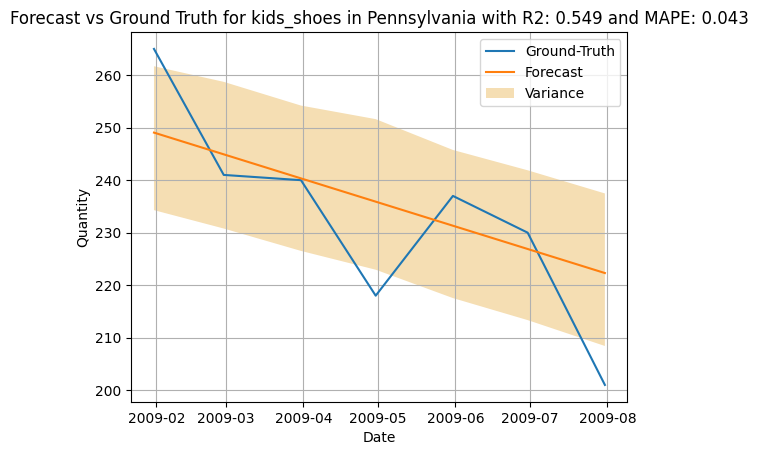

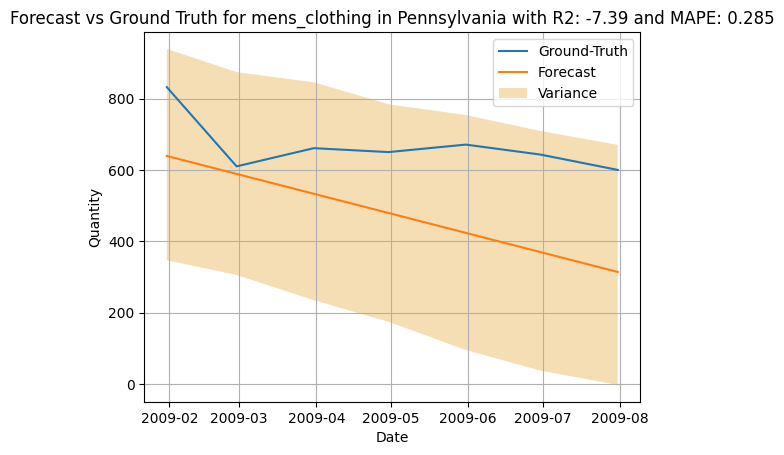

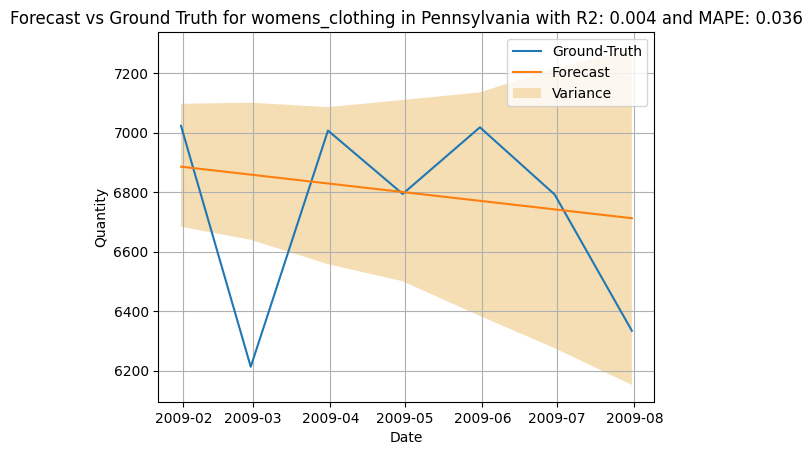

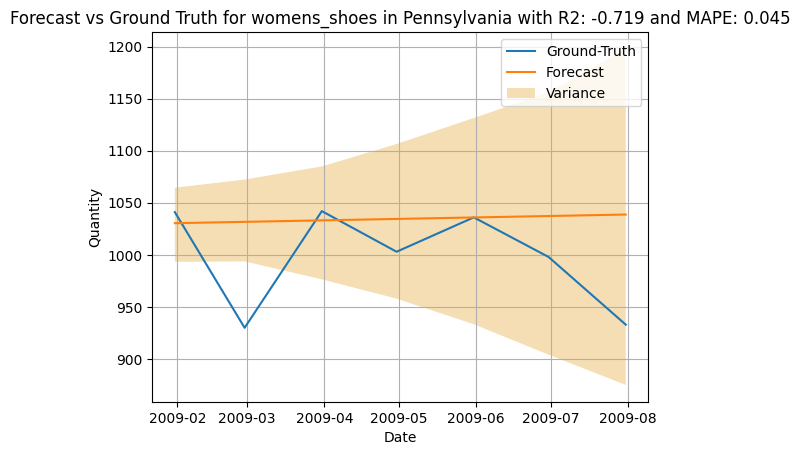

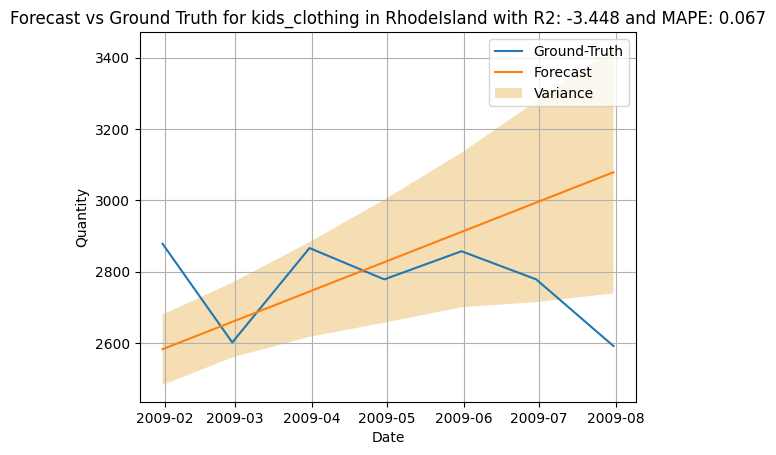

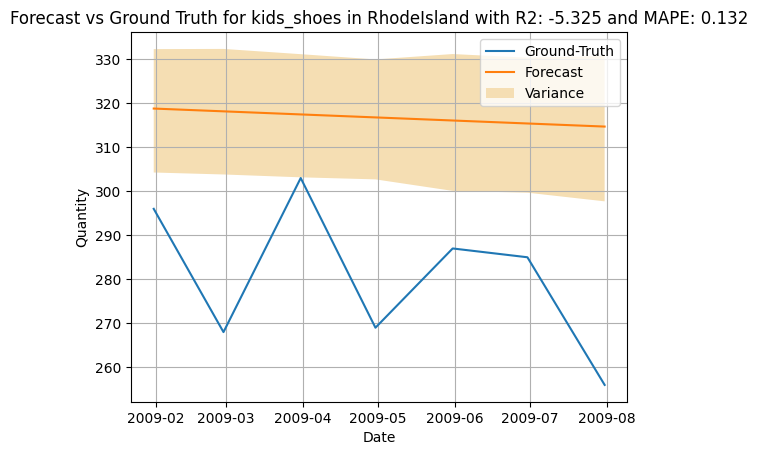

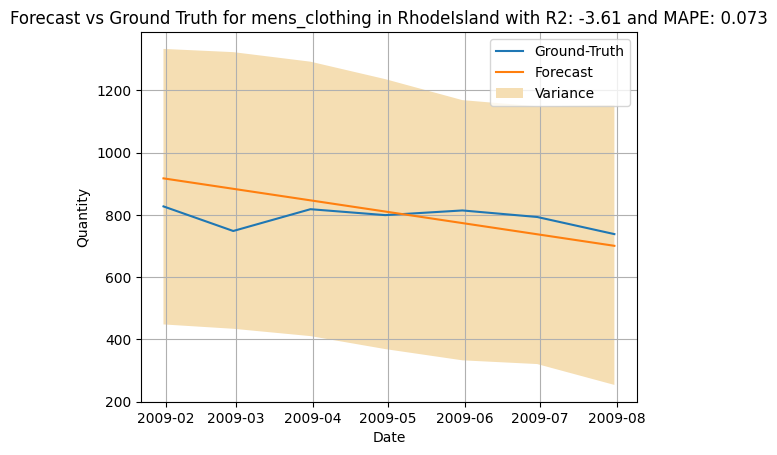

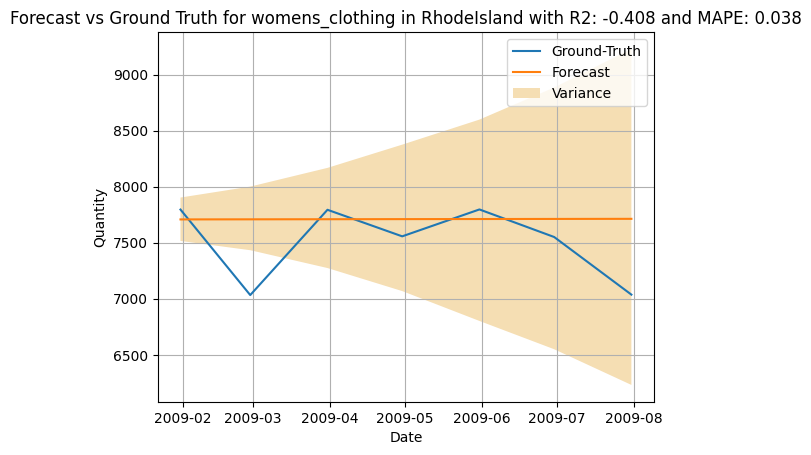

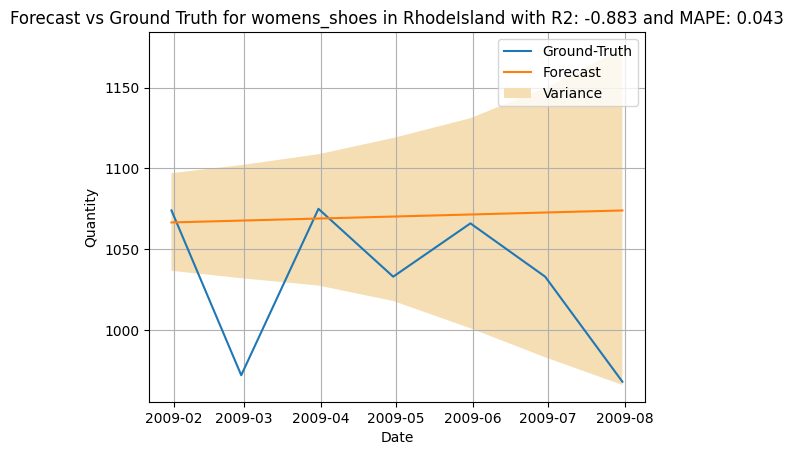

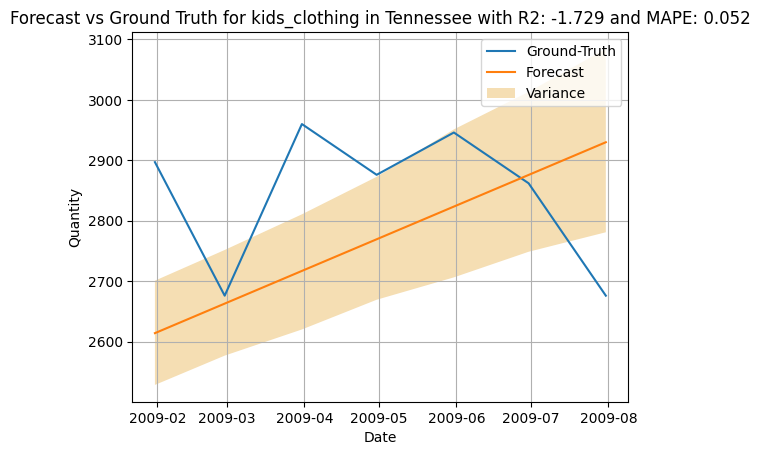

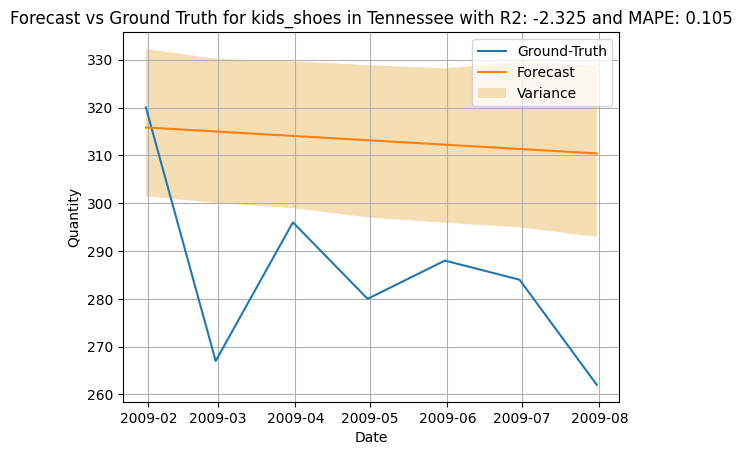

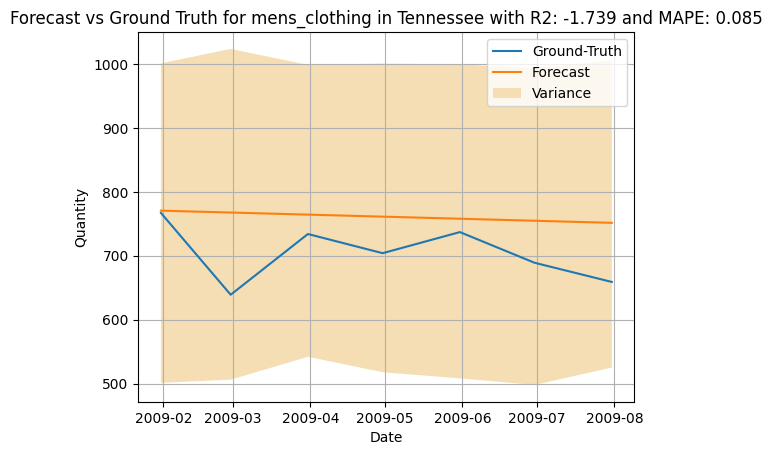

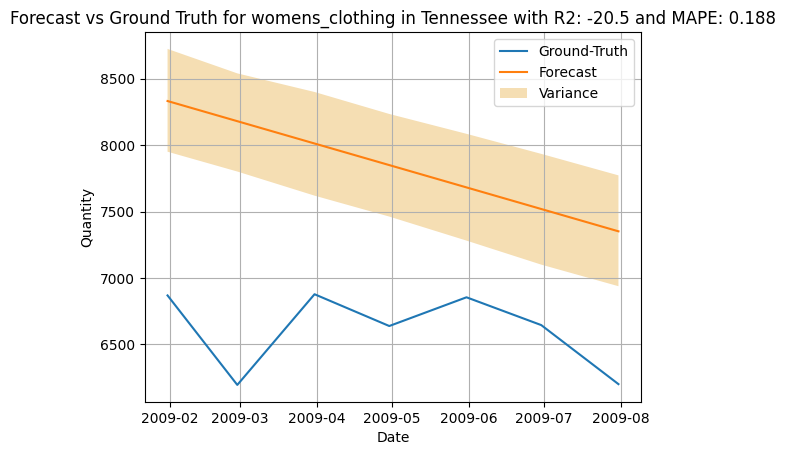

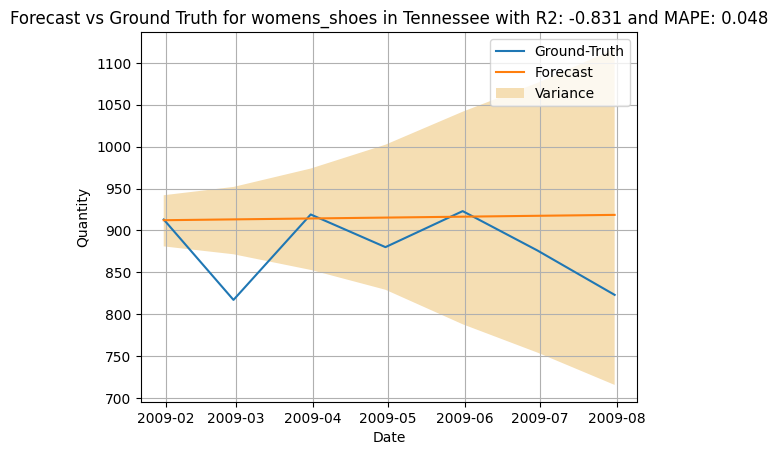

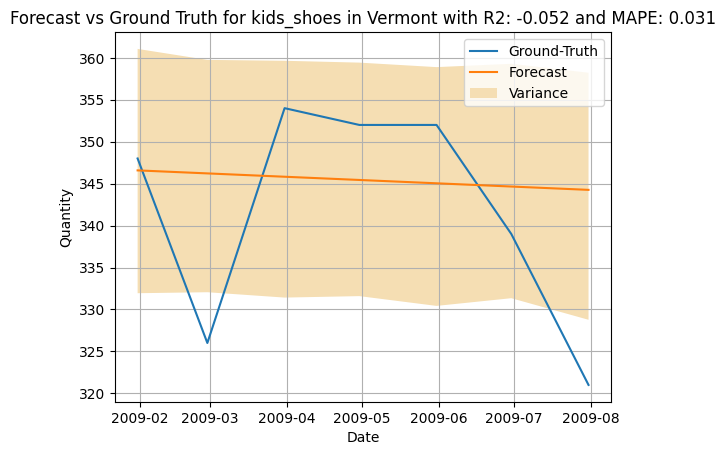

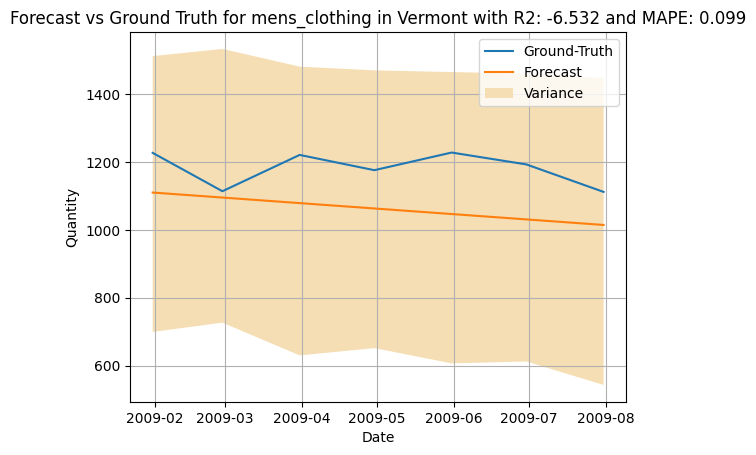

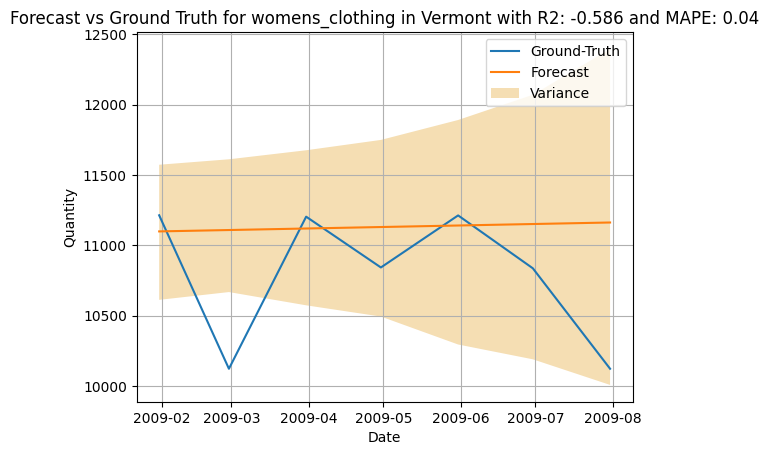

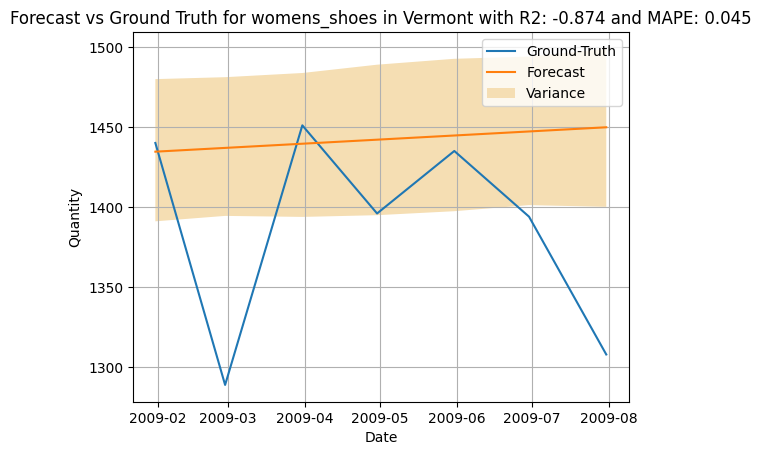

In [304]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_percentage_error
metrics={}
for i in df_gt.index.unique(level=0): # Total 91 unique combinations
    r2_score_each_combo=r2_score(df_gt.loc[[i]].values,forecasts_df.loc[[i]]["yhat"].values)
    mean_absolute_percentage_error_each_combo=mean_absolute_percentage_error(df_gt.loc[[i]].values,forecasts_df.loc[[i]]["yhat"].values)
    metrics[i]={"R2":r2_score_each_combo,"MAPE":mean_absolute_percentage_error_each_combo}
    plt.plot(df_gt.loc[i].index,df_gt.loc[i].values)
    plt.plot(forecasts_df.loc[i].index,forecasts_df.loc[i]['yhat'])
    plt.fill_between(forecasts_df.loc[i].index,forecasts_df.loc[i]['yhat_lower'],forecasts_df.loc[i]['yhat_upper'],facecolor='wheat')
    plt.title(f"Forecast vs Ground Truth for {i.split('/')[1]} in {i.split('/')[0]} with R2: {round(r2_score_each_combo,3)} and MAPE: {round(mean_absolute_percentage_error_each_combo,3)}")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend(['Ground-Truth',"Forecast","Variance"])
    plt.grid(True)
    plt.show()

In [303]:
metrics

{'Alabama/kids_clothing': {'R2': -1.5098075714368062,
  'MAPE': 0.08468016128130705},
 'Alabama/kids_shoes': {'R2': -2.368392403496406, 'MAPE': 0.07931963583800823},
 'Alabama/mens_clothing': {'R2': -206.2774039399239,
  'MAPE': 0.7923060821243567},
 'Alabama/mens_shoes': {'R2': -0.9874997969697554,
  'MAPE': 0.05195072616660117},
 'Alabama/womens_clothing': {'R2': -0.9170939291246993,
  'MAPE': 0.041616152462281016},
 'Alabama/womens_shoes': {'R2': -0.4911764438880726,
  'MAPE': 0.03607151539965847},
 'Alaska/kids_clothing': {'R2': -25.85982187461472,
  'MAPE': 0.20282684767241616},
 'Alaska/kids_shoes': {'R2': -0.10623757107540666,
  'MAPE': 0.049292263513503534},
 'Alaska/mens_clothing': {'R2': -0.4196961287704699,
  'MAPE': 0.11492833153019404},
 'Alaska/womens_clothing': {'R2': -1.3083136699406475,
  'MAPE': 0.050292606213608614},
 'Alaska/womens_shoes': {'R2': -0.2968316095249619,
  'MAPE': 0.028024145945745642},
 'California/kids_clothing': {'R2': -1.4676611305382186,
  'MAPE': 

In [287]:
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

In [288]:
# Define the parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

In [289]:
df_raw = df_raw.rename(columns={'date': 'ds', 'quantity': 'y'})


In [ ]:
# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit model with given params
    model = Prophet(**params)
    model.fit(df_raw)  
    
    # Cross validate
    df_cv = cross_validation(model, horizon='10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    # Store RMSE
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
best_params = tuning_results.loc[tuning_results['rmse'].idxmin()]
print("Best Parameters:")
print(best_params)

16:44:01 - cmdstanpy - INFO - Chain [1] start processing
16:44:02 - cmdstanpy - INFO - Chain [1] done processing
16:44:52 - cmdstanpy - INFO - Chain [1] start processing
16:44:54 - cmdstanpy - INFO - Chain [1] done processing
16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:45 - cmdstanpy - INFO - Chain [1] done processing
16:46:33 - cmdstanpy - INFO - Chain [1] start processing
16:46:34 - cmdstanpy - INFO - Chain [1] done processing
16:47:23 - cmdstanpy - INFO - Chain [1] start processing
16:47:24 - cmdstanpy - INFO - Chain [1] done processing
16:48:17 - cmdstanpy - INFO - Chain [1] start processing
16:48:18 - cmdstanpy - INFO - Chain [1] done processing
16:52:29 - cmdstanpy - INFO - Chain [1] start processing
16:52:30 - cmdstanpy - INFO - Chain [1] done processing
16:53:25 - cmdstanpy - INFO - Chain [1] start processing
16:53:25 - cmdstanpy - INFO - Chain [1] done processing
16:54:17 - cmdstanpy - INFO - Chain [1] start processing
16:54:18 - cmdstanpy - INFO - Chain [1]

In [ ]:
# Python
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse         rmse          mae      mape     mdape  \
0  4 days  2.871284e+06  1694.486251  1216.014509  1.572989  0.793789   
1  5 days  2.725672e+06  1650.960864  1190.159957  1.554567  0.802769   
2  6 days  2.442240e+06  1562.766931  1142.771297  1.554131  0.796987   
3  7 days  2.595671e+06  1611.108693  1162.990514  1.534064  0.791604   
4  8 days  2.929091e+06  1711.458639  1205.348276  1.505113  0.768363   

      smape  coverage  
0  0.790940  0.829271  
1  0.784925  0.820634  
2  0.789281  0.819762  
3  0.787306  0.823660  
4  0.778807  0.828526